In [1]:
# All imports
import pdb
import os
from pickletools import optimize
from shutil import SpecialFileError
import time
import random
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter

from config import get_config
from models import build_model
from data import build_loader
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, load_pretrained, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
import re
import torch.nn.functional as F

In [3]:
# Init args
def parse_option(config_path, output_path, tag):
    parser = argparse.ArgumentParser('Swin Transformer training and evaluation script', add_help=False)
    parser.add_argument('--cfg', type=str, default=config_path, metavar="FILE", help='path to config file', )
    parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )

    # easy config modification
    parser.add_argument('--batch-size', type=int, help="batch size for single GPU")
    parser.add_argument('--data-path', type=str, help='path to dataset')
    parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
    parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                        help='no: no cache, '
                             'full: cache all data, '
                             'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
    parser.add_argument('--num-workers', type=int, help="Number of data loading threads")
    parser.add_argument('--pretrained',
                        help='pretrained weight from checkpoint, could be imagenet22k pretrained weight')
    parser.add_argument('--resume', help='resume from checkpoint')
    parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
    parser.add_argument('--use-checkpoint', action='store_true',
                        help="whether to use gradient checkpointing to save memory")
    parser.add_argument('--amp-opt-level', type=str, default='O1', choices=['O0', 'O1', 'O2'],
                        help='mixed precision opt level, if O0, no amp is used')
    parser.add_argument('--native-amp', action='store_true', default=False,
                        help='Use Native Torch AMP mixed precision')
    parser.add_argument('--ffcv', action='store_true', default=False)
    parser.add_argument('--output', default='output', type=str, metavar='PATH',
                        help='root of output folder, the full path is <output>/<model_name>/<tag> (default: output)')
    parser.add_argument('--tag', help='tag of experiment')
    parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
    parser.add_argument('--throughput', action='store_true', help='Test throughput only')
#     parser.add_argument('--ffcv', action='store_true')
    parser.add_argument('--native_amp', action='store_true')
    parser.add_argument('--num_workers', default=8)
    
    # distributed training
    # distributed training
    parser.add_argument(
        "--local_rank", type=int, help='local rank for DistributedDataParallel', default=0
    )

    args, unparsed = parser.parse_known_args()
    config = get_config(args)

    return args, config

def build_val_loader(config):
    from data.build import build_dataset
    from timm.data import Mixup
    config.defrost()
    dataset_train, config.MODEL.NUM_CLASSES = build_dataset(is_train=True, config=config)
    config.freeze()
    dataset_val, _ = build_dataset(is_train=False, config=config)

    

    sampler_val = torch.utils.data.RandomSampler(dataset_val)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=config.DATA.BATCH_SIZE,
#         shuffle=True,
        num_workers=config.DATA.NUM_WORKERS,
        pin_memory=config.DATA.PIN_MEMORY,
        drop_last=False
    )

    # setup mixup / cutmix
    mixup_fn = None
    mixup_active = config.AUG.MIXUP > 0 or config.AUG.CUTMIX > 0. or config.AUG.CUTMIX_MINMAX is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=config.AUG.MIXUP, cutmix_alpha=config.AUG.CUTMIX, cutmix_minmax=config.AUG.CUTMIX_MINMAX,
            prob=config.AUG.MIXUP_PROB, switch_prob=config.AUG.MIXUP_SWITCH_PROB, mode=config.AUG.MIXUP_MODE,
            label_smoothing=config.MODEL.LABEL_SMOOTHING, num_classes=config.MODEL.NUM_CLASSES)

    return dataset_val, data_loader_val, mixup_fn

@torch.no_grad()
def validate(config, data_loader, model, accumulation_steps=1):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        formatted_images = images.cuda(non_blocking=True).unsqueeze(0)
        formatted_target = target.cuda(non_blocking=True).unsqueeze(0)
        
        A, B, C, H, W = formatted_images.shape
        A, B = formatted_target.shape
        if B // accumulation_steps == 0:
            zero_idx = 1
            ones_idx = B
        else:
            zero_idx = accumulation_steps
            ones_idx = B // accumulation_steps
        formatted_images = formatted_images.reshape(zero_idx, ones_idx, C, H, W)
        formatted_target = formatted_target.reshape(zero_idx, ones_idx)
        
        for accumulation_step in range(accumulation_steps):
            images = formatted_images[accumulation_step]
            target = formatted_target[accumulation_step]
        
            # compute output
            output = model(images, use_amp=False)

            # measure accuracy and record loss
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

    #         acc1 = acc1
    #         acc5 = reduce_tensor(acc5)
    #         loss = reduce_tensor(loss)

            loss_meter.update(loss.item(), target.size(0))
            acc1_meter.update(acc1.item(), target.size(0))
            acc5_meter.update(acc5.item(), target.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % config.PRINT_FREQ == 0:
                memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
                print(
                    f'Test: [{idx}/{len(data_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                    f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                    f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                    f'Mem {memory_used:.0f}MB')
            images = images.cpu()
            target = target.cpu()
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

In [35]:
id2label = {}
with open('/nethome/gstoica3/research/Swin-Transformer/data/imagenet_classnames.txt', 'r') as handle:
    for idx, line in enumerate(handle):
            element, label = line.strip().split(': ')
            id2label[int(element)] = str(label[:-1]).split(',')[0]

In [36]:
id2label

{0: 'tench',
 1: 'goldfish',
 2: 'great white shark',
 3: 'tiger shark',
 4: 'hammerhead',
 5: 'electric ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house finch',
 13: 'junco',
 14: 'indigo bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel',
 21: 'kite',
 22: 'bald eagle',
 23: 'vulture',
 24: 'great grey owl',
 25: 'European fire salamander',
 26: 'common newt',
 27: 'eft',
 28: 'spotted salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree frog',
 32: 'tailed frog',
 33: 'loggerhead',
 34: 'leatherback turtle',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle',
 38: 'banded gecko',
 39: 'common iguana',
 40: 'American chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled lizard',
 44: 'alligator lizard',
 45: 'Gila monster',
 46: 'green lizard',
 47: 'African chameleon',
 48: 'Komodo dragon',
 49: 'African crocodile',
 50: 'American alligator',
 51: 'triceratops',
 

# Loading Models
All you need to do to load the models is run everything sequentially up to "Visualize Filters." Each model has a separate dataloader - for some reason you cannot use one model's dataloader for another... - and we can check that they are properly loaded through the "validate" function. Hopefully you'll find the baseline gets ~77.41% and ours gets 79.01%. 

### Reversed Attention Model

In [6]:
our_config_path = 'configs/biswin_tiny_patch4_window7_224.yaml'
our_output_path = '/srv/share4/gstoica3/checkpoints/ImageNetScratchSwinBiSA0/biswin_tiny_patch4_window7_224'
our_tag = 'NoNorm'
_, our_config = parse_option(our_config_path, our_output_path, our_tag)

=> merge config from configs/biswin_tiny_patch4_window7_224.yaml


In [7]:
csam_seed = our_config.SEED
torch.manual_seed(csam_seed)
torch.cuda.manual_seed(csam_seed)
np.random.seed(csam_seed)
random.seed(csam_seed)
cudnn.benchmark = True

In [8]:
our_config.defrost()
our_config.TRAIN.BASE_LR = .000001
our_config.TRAIN.WARMUP_LR = .000001
our_config.TRAIN.MIN_LR = .000001
# our_config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
our_config.freeze()

In [9]:
our_dataset_val, our_data_loader_val, our_mixup_fn = build_val_loader(our_config)

In [10]:
our_model = build_model(our_config)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
our_model.cuda()
# our_resume_file = auto_resume_helper(our_config.OUTPUT)
our_resume_file = '/srv/share4/gstoica3/checkpoints/ContinualLearningHybridBaseSecongStageHead/biswin_tiny_patch4_window7_224/CorrectTransposeSoftmaxSelectionLambdaMatrix/ckpt_epoch_15.pth'
our_config.defrost()
our_config.MODEL.PRETRAINED = our_resume_file
our_config.freeze()
load_pretrained(our_config, our_model)

In [20]:
stop_idx = 2
captured_images = []
captured_labels = []
for idx, (images, labels) in enumerate(our_data_loader_val):
    
    captured_images.append(images)
    captured_labels.append(labels)
    if idx >= stop_idx: break

captured_images = torch.cat(captured_images, dim=0)
captured_labels = torch.cat(captured_labels, dim=0)

In [29]:
random_indices = np.random.choice(captured_images.shape[0], 25, replace=False)
random_indices.shape, random_indices

((25,),
 array([259, 278, 317, 208,  54,  12, 159, 288, 376, 316,  10, 377, 183,
        206, 282, 172,  37,  96, 284, 142, 323, 171, 198, 205,  21]))

In [25]:
MEAN = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
STD = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
# np.transpose((images[b] * STD) + MEAN, (1,2,0))

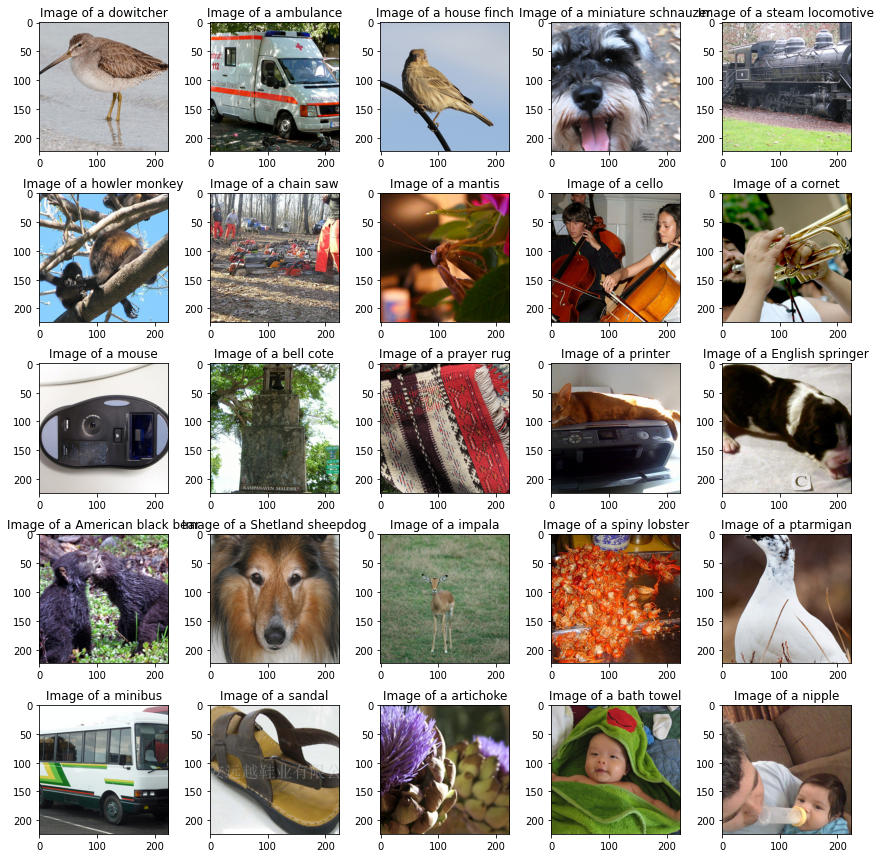

In [38]:
fig, ax = plt.subplots(5, 5)
fig.set_size_inches(12, 12)
fig.tight_layout()
for i in range(5):
    for j in range(5):
        idx = random_indices[i * 5 + j]
        ax[i, j].imshow(np.clip(np.transpose((captured_images[idx] * STD) + MEAN, (1,2,0)), a_min=0., a_max=1.))
        ax[i, j].set_title("Image of a {}".format(id2label[captured_labels[idx].detach().numpy().tolist()]))

fig.show()

# [OLD] Swin Transformer Baseline

In [52]:
bl_config_path = 'configs/swin_tiny_patch4_window7_224.yaml'
bl_output_path = '/srv/share4/gstoica3/checkpoints/swin_transformer'
bl_tag = 'baseline_fp32'
_, bl_config = parse_option(bl_config_path, bl_output_path, bl_tag)

=> merge config from configs/swin_tiny_patch4_window7_224.yaml


In [28]:
bl_config

CfgNode({'BASE': [''], 'DATA': CfgNode({'BATCH_SIZE': 128, 'DATA_PATH': '/srv/datasets/ImageNet', 'DATASET': 'imagenet', 'IMG_SIZE': 224, 'INTERPOLATION': 'bicubic', 'ZIP_MODE': False, 'CACHE_MODE': 'part', 'PIN_MEMORY': True, 'NUM_WORKERS': 8}), 'MODEL': CfgNode({'TYPE': 'swin', 'NAME': 'swin_tiny_patch4_window7_224', 'PRETRAINED': '', 'RESUME': '', 'NUM_CLASSES': 1000, 'DROP_RATE': 0.0, 'DROP_PATH_RATE': 0.2, 'LABEL_SMOOTHING': 0.1, 'SWIN': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'QKV_BIAS': True, 'QK_SCALE': None, 'APE': False, 'PATCH_NORM': True, 'SUMMARY_TYPE': 'none', 'SUMMARY_LAYERS': [], 'REVERSE_ATTENTION_LOCATIONS': [], 'ALTERED_ATTENTION': CfgNode({'TYPE': 'forward', 'REDUCE_REVERSE': False, 'REVERSE_ACTIVATION': 'none', 'HYPERNETWORK_BIAS': True, 'PROJECT_VALUES': True, 'PROJECT_INPUT': True, 'VALUE_IS_INPUT': False, 'TRANSPOSE_SOFTMAX': True, 'ACTIVATE_HYPER_WEIGHTS':

In [54]:
bl_seed = bl_config.SEED
torch.manual_seed(bl_seed)
torch.cuda.manual_seed(bl_seed)
np.random.seed(bl_seed)
random.seed(bl_seed)
cudnn.benchmark = True

In [55]:
bl_config.defrost()
bl_config.TRAIN.BASE_LR = .000001
bl_config.TRAIN.WARMUP_LR = .000001
bl_config.TRAIN.MIN_LR = .000001
# bl_config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
bl_config.freeze()

In [57]:
bl_dataset_val, bl_data_loader_val, bl_mixup_fn = build_val_loader(bl_config)

In [32]:
bl_model = build_model(bl_config)
bl_model.cuda()
print()

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
bl_resume_file = auto_resume_helper(bl_config.OUTPUT)
bl_config.defrost()
bl_config.MODEL.PRETRAINED = bl_resume_file
bl_config.freeze()
load_pretrained(bl_config, bl_model)

All checkpoints founded in /srv/share4/gstoica3/checkpoints/swin_transformer_cifar/swin_tiny_patch4_window7_224_cifar100/baseline_fp32: ['ckpt_epoch_11.pth', 'ckpt_epoch_228.pth', 'ckpt_epoch_143.pth', 'ckpt_epoch_285.pth', 'ckpt_epoch_254.pth', 'ckpt_epoch_192.pth', 'ckpt_epoch_144.pth', 'ckpt_epoch_282.pth', 'ckpt_epoch_253.pth', 'ckpt_epoch_195.pth', 'ckpt_epoch_16.pth', 'ckpt_epoch_138.pth', 'ckpt_epoch_305.pth', 'ckpt_epoch_64.pth', 'ckpt_epoch_18.pth', 'ckpt_epoch_136.pth', 'ckpt_epoch_221.pth', 'ckpt_epoch_131.pth', 'ckpt_epoch_226.pth', 'ckpt_epoch_302.pth', 'ckpt_epoch_63.pth', 'ckpt_epoch_213.pth', 'ckpt_epoch_104.pth', 'ckpt_epoch_87.pth', 'ckpt_epoch_56.pth', 'ckpt_epoch_5.pth', 'ckpt_epoch_178.pth', 'ckpt_epoch_80.pth', 'ckpt_epoch_51.pth', 'ckpt_epoch_2.pth', 'ckpt_epoch_268.pth', 'ckpt_epoch_214.pth', 'ckpt_epoch_103.pth', 'ckpt_epoch_266.pth', 'ckpt_epoch_171.pth', 'ckpt_epoch_23.pth', 'ckpt_epoch_24.pth', 'ckpt_epoch_89.pth', 'ckpt_epoch_58.pth', 'ckpt_epoch_261.pth', 

# Visualize Attention Matrices

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


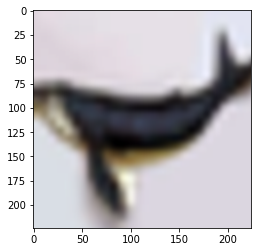

In [272]:
MEAN = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
STD = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
plt.imshow(np.transpose((better_images[17] * STD) + MEAN, (1,2,0)))

In [274]:
attn_image_index1 = random_our_correct_bl_wrong_ids[17]
attn_image_index1

7071

In [297]:
our_model.eval()
patched_image = our_model.patch_embed(
    torch.from_numpy(np.array(all_images)[attn_image_index1]).cuda(non_blocking=True).unsqueeze(0)
)
if our_model.ape:
    patched_image += our_model.absolute_pos_embed
x = our_model.pos_drop(patched_image)

In [298]:
x.shape

torch.Size([1, 3136, 96])

In [299]:
attention_layer = our_model.layers[0]
self = attention_layer.blocks[0]

In [300]:
H, W = self.input_resolution
B, L, C = x.shape
try:
    assert L == H * W, "input feature has wrong size"
except:
    pdb.set_trace()

shortcut = x
x = self.norm1(x)
x = x.view(B, H, W, C)

# cyclic shift
if self.shift_size > 0:
    shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
else:
    shifted_x = x

# partition windows
x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

# W-MSA/SW-MSA

In [302]:
x_windows.shape

torch.Size([64, 49, 96])

In [313]:
def plot_windows(patched_image):
    pca = PCA(n_components=3)
    Nw, K2, C = x_windows.shape
    flattened_image = patched_image.flatten(0,1).detach().cpu().numpy()
    reduced_image = pca.fit_transform(flattened_image)
    
    side = int(Nw ** .5)
    K = int(K2 ** .5)
    reshaped_image = reduced_image.reshape(Nw, K2, 3).reshape(side, side, K, K, 3)
    fig, ax = plt.subplots(side, side)
    fig.set_size_inches(4 * side, 4 * side)
    for i in range(side):
        for j in range(side):
            ax[i, j].imshow(sigmoid(reshaped_image[i,j]))
            ax[i, j].set_title('Index: ({},{})'.format(i, j))

    fig.show()

In [316]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def get_reverse_attn_tensor(self, x, mask=None):
    BW, K2, C = x.shape
    qk = self.reverse_qk(x).reshape(BW, K2, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k = qk[0], qk[1]  # make torchscript happy (cannot use tensor as tuple)
    v = self.reverse_v(x).reshape(BW, K2, self.num_heads, C // self.num_heads).transpose(2, 1)
    q = q * self.scale
    attn = (q @ k.transpose(-2, -1))

    relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
        self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
    relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
    attn = attn + relative_position_bias.unsqueeze(0)

    if mask is not None:
        nW = mask.shape[0]
        attn = attn.view(BW // nW, nW, self.num_heads, K2, K2) + mask.unsqueeze(1).unsqueeze(0)
        attn = attn.view(-1, self.num_heads, K2, K2)
        attn = self.softmax(attn)
    else:
        attn = self.softmax(attn)

    attn = self.reverse_attn_drop(attn).transpose(-2, -1) # [BW, h, K2, K2]

    return attn


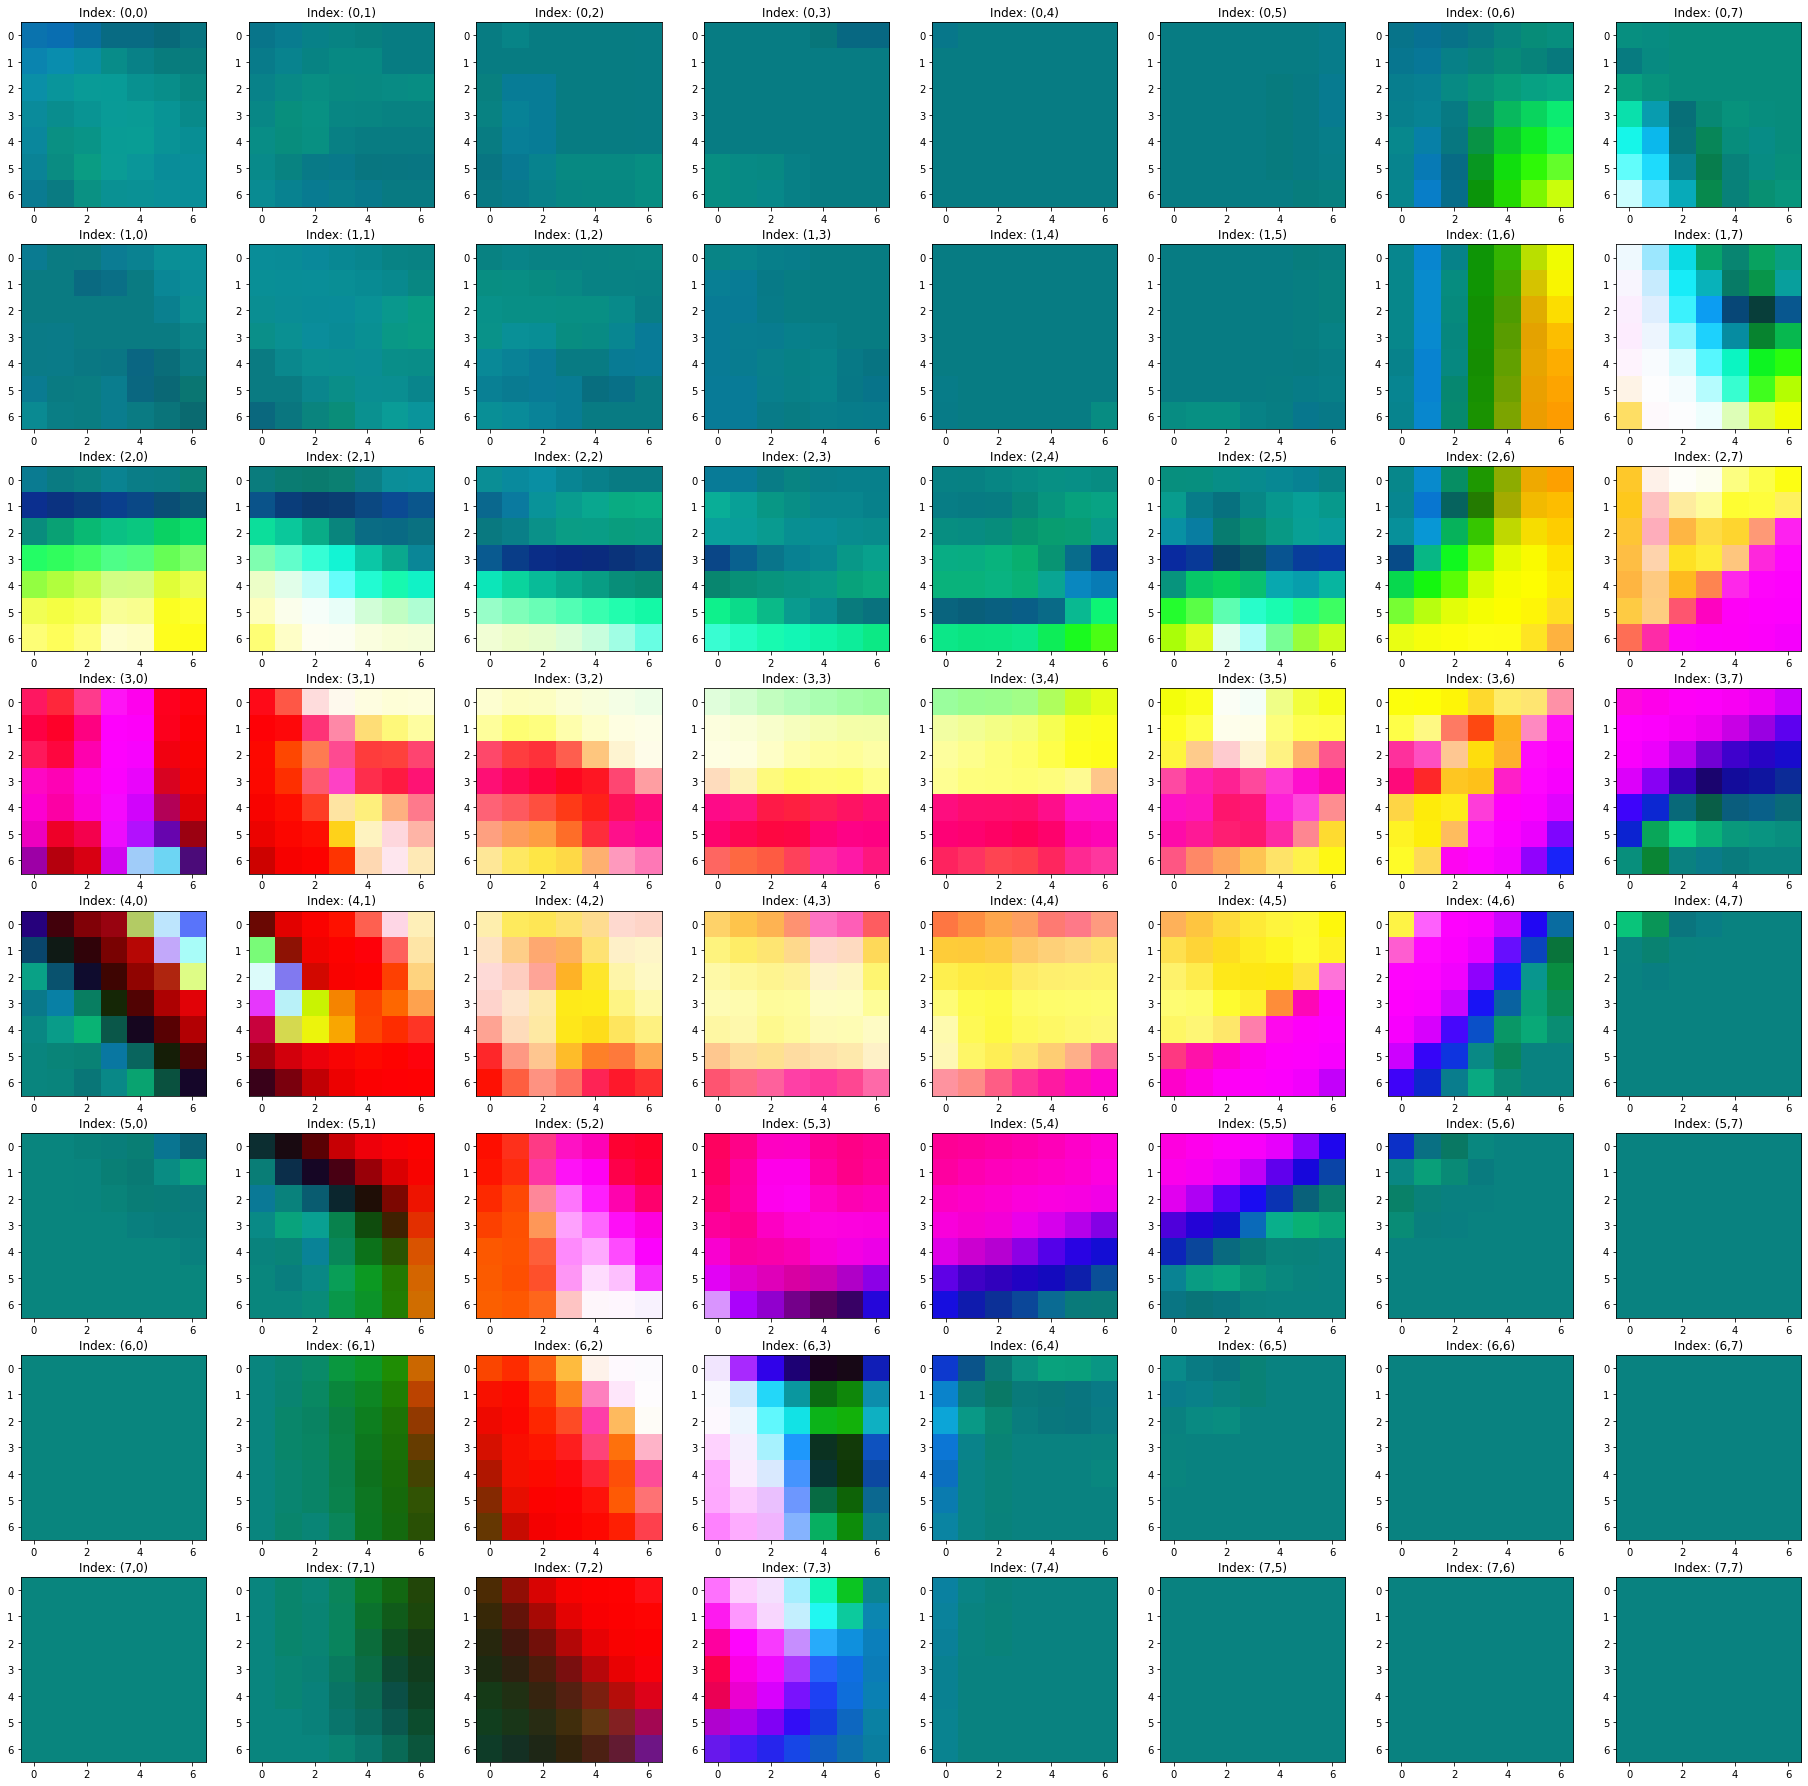

In [314]:
plot_windows(x_windows)

In [315]:
foreground_idx = [6, 3]
background_idx = [7, 5]

In [319]:
window_attn_matrix = get_reverse_attn_tensor(self.attn, x_windows)

In [320]:
window_attn_matrix.shape

torch.Size([64, 3, 49, 49])

In [340]:
def visualize_window_attn(attn_window, title=''):
    K2, K2 = attn_window.shape
    K = int(K2 ** .5)
    window = attn_window.reshape(K, K, K, K)
    fig, ax = plt.subplots(K, K)
    fig.set_size_inches(4 * K, 4 * K)
    for i in range(K):
        for j in range(K):
            plot = ax[i, j].imshow(window[i,j])
            plt.colorbar(plot, ax=ax[i, j])
            ax[i,j].set_title('Index: ({},{})'.format(i, j))
    fig.suptitle(title)
    fig.show()

def plot_selected_attn(attn_matrix, index):
    Nw, h, K2, K2 = attn_matrix.shape
    side = int(Nw ** .5)
    attn_matrix_r = attn_matrix.reshape(side, side, h, K2, K2).detach().cpu().numpy()
    attn_at_index = attn_matrix_r[index[0], index[1]]
    for i in range(h):
        visualize_window_attn(attn_at_index[i], title='Attention Maps for head {} at Index {}'.format(i, index))
    

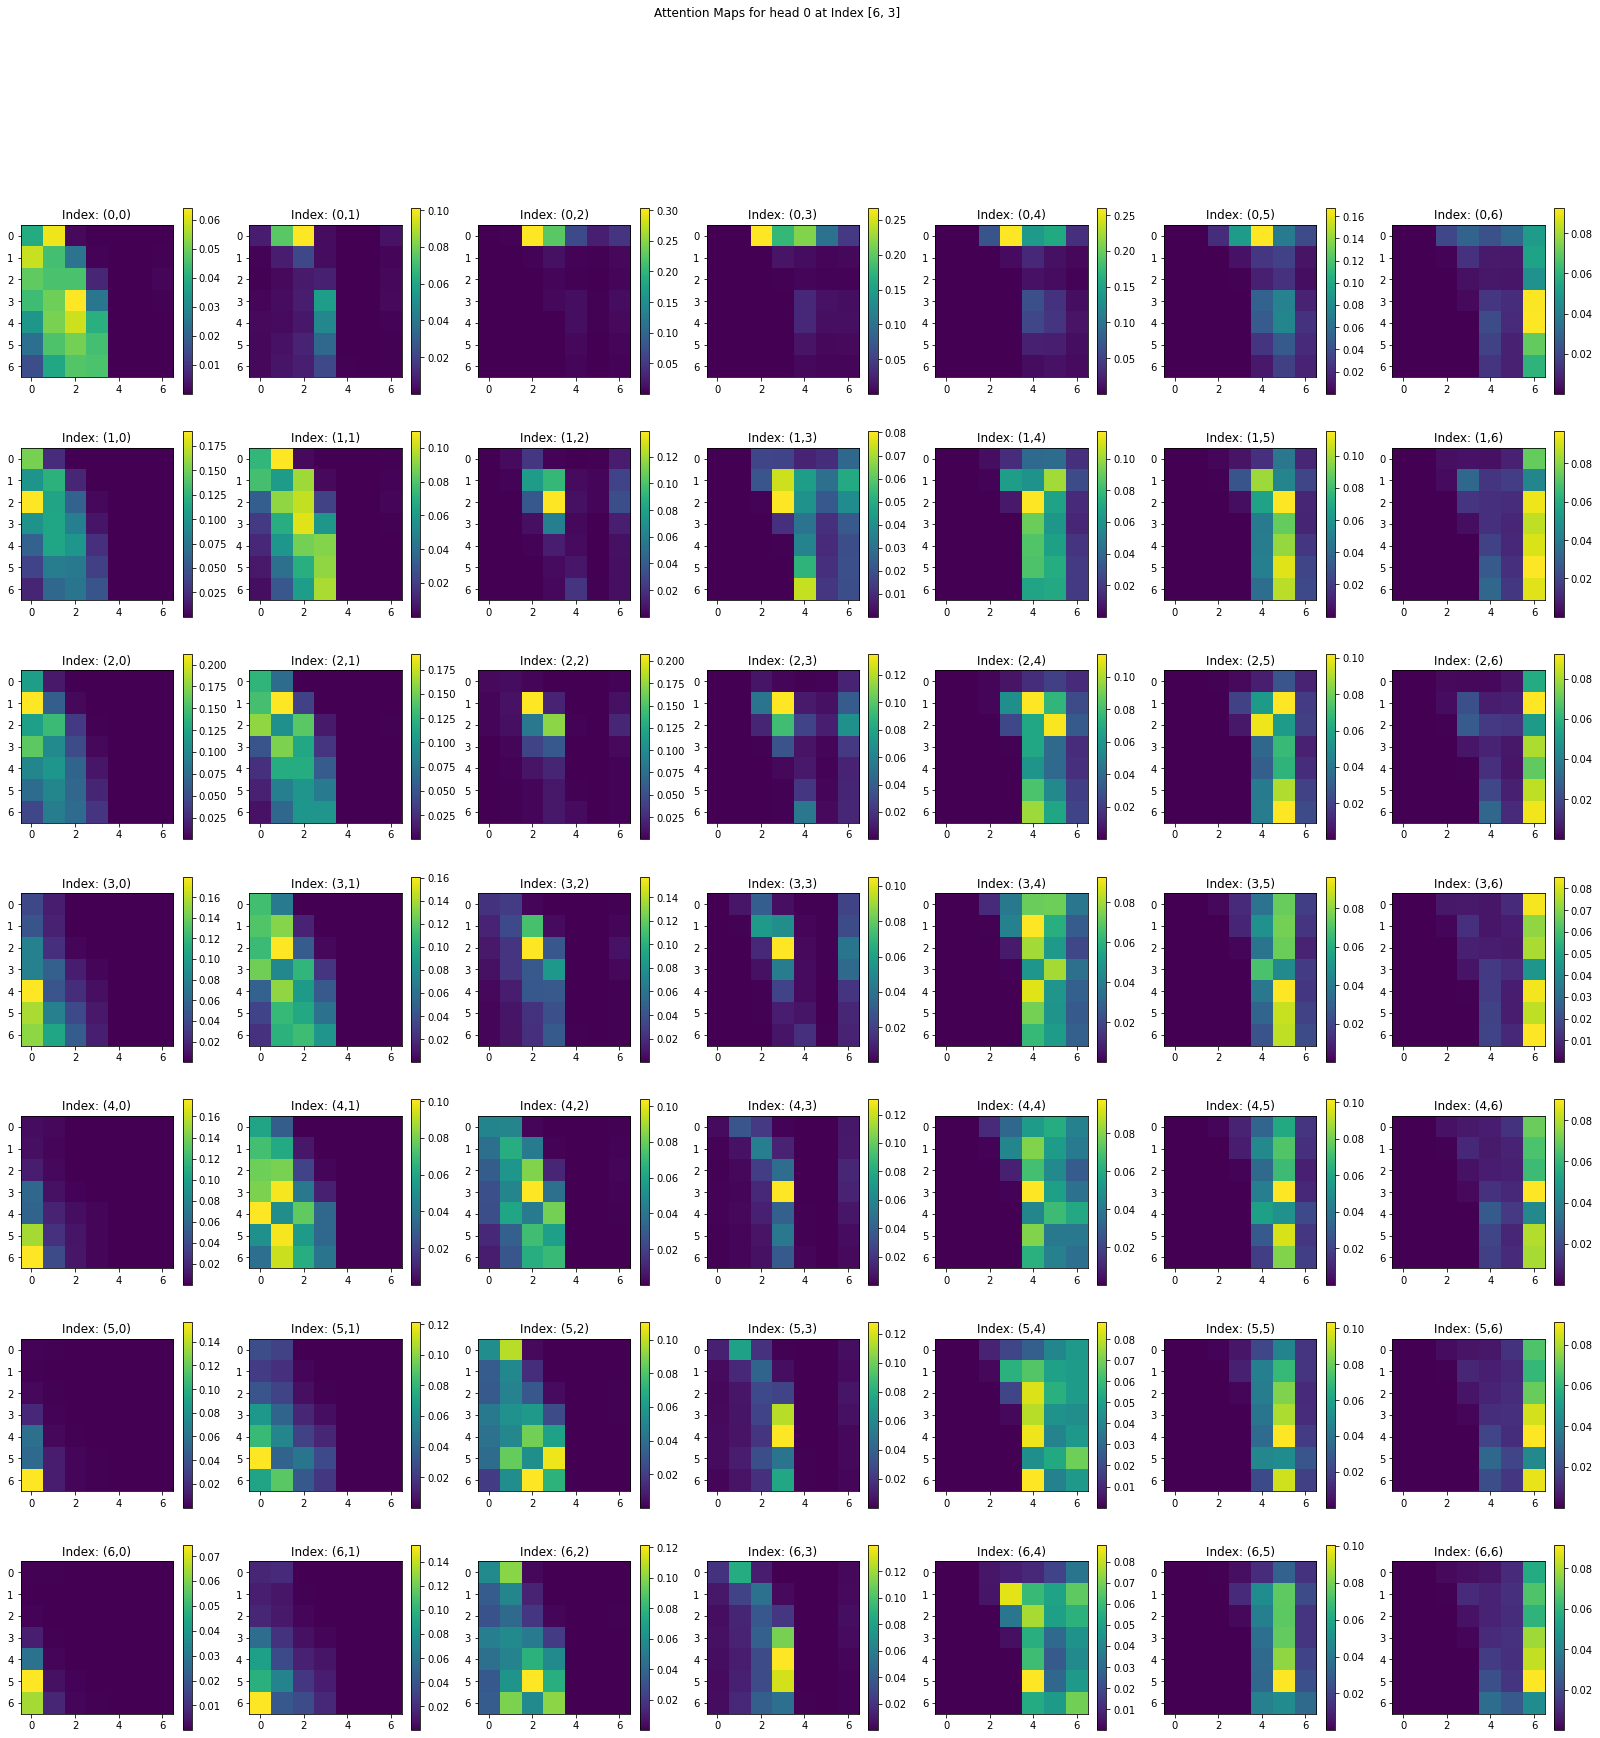

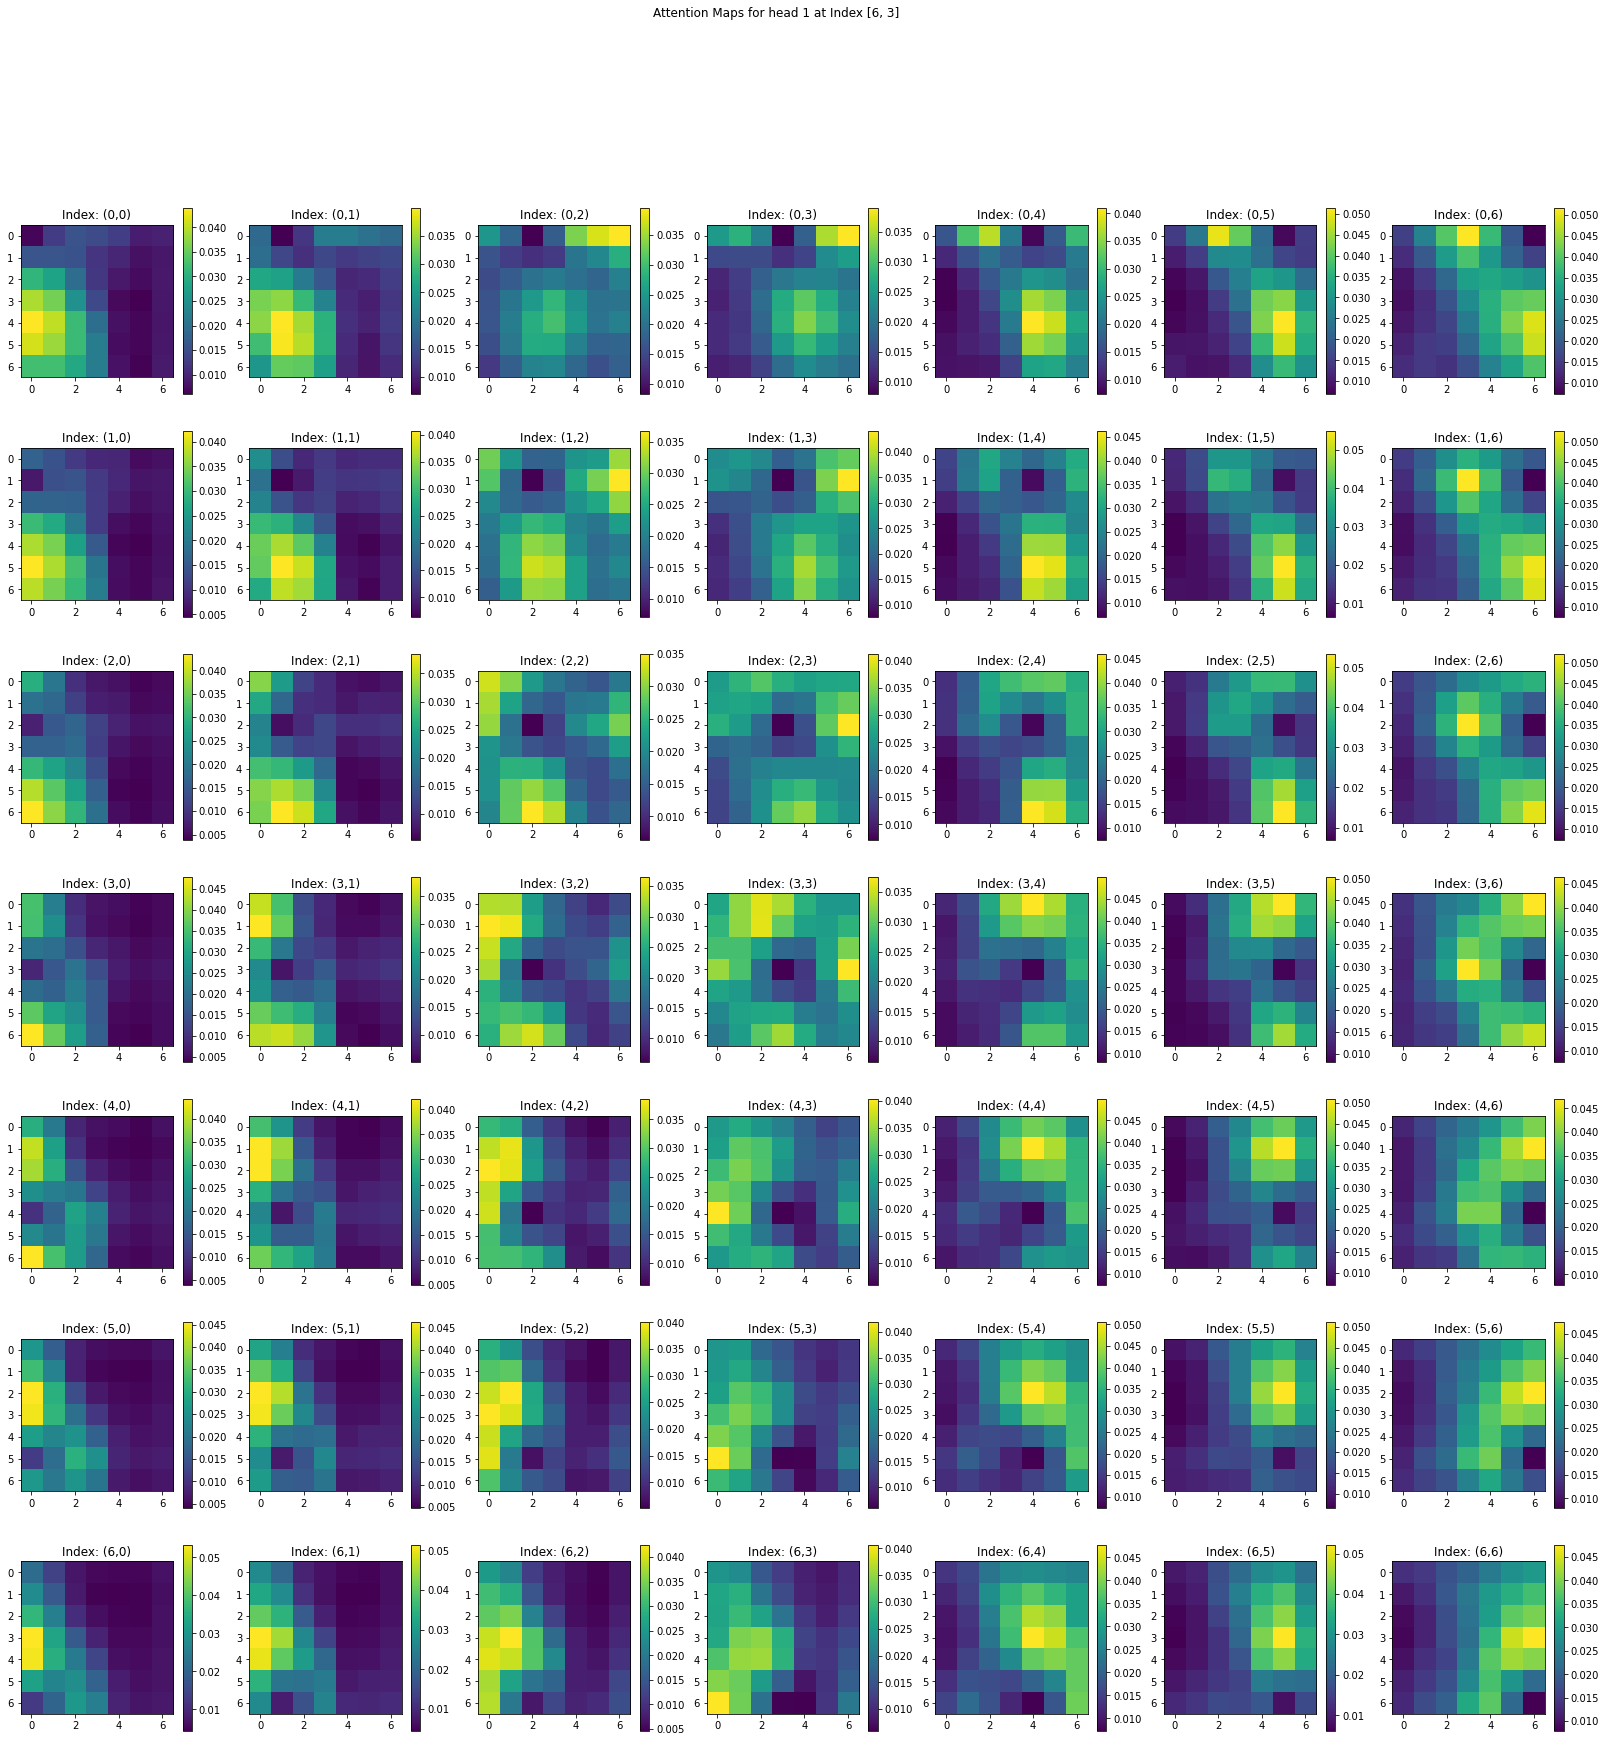

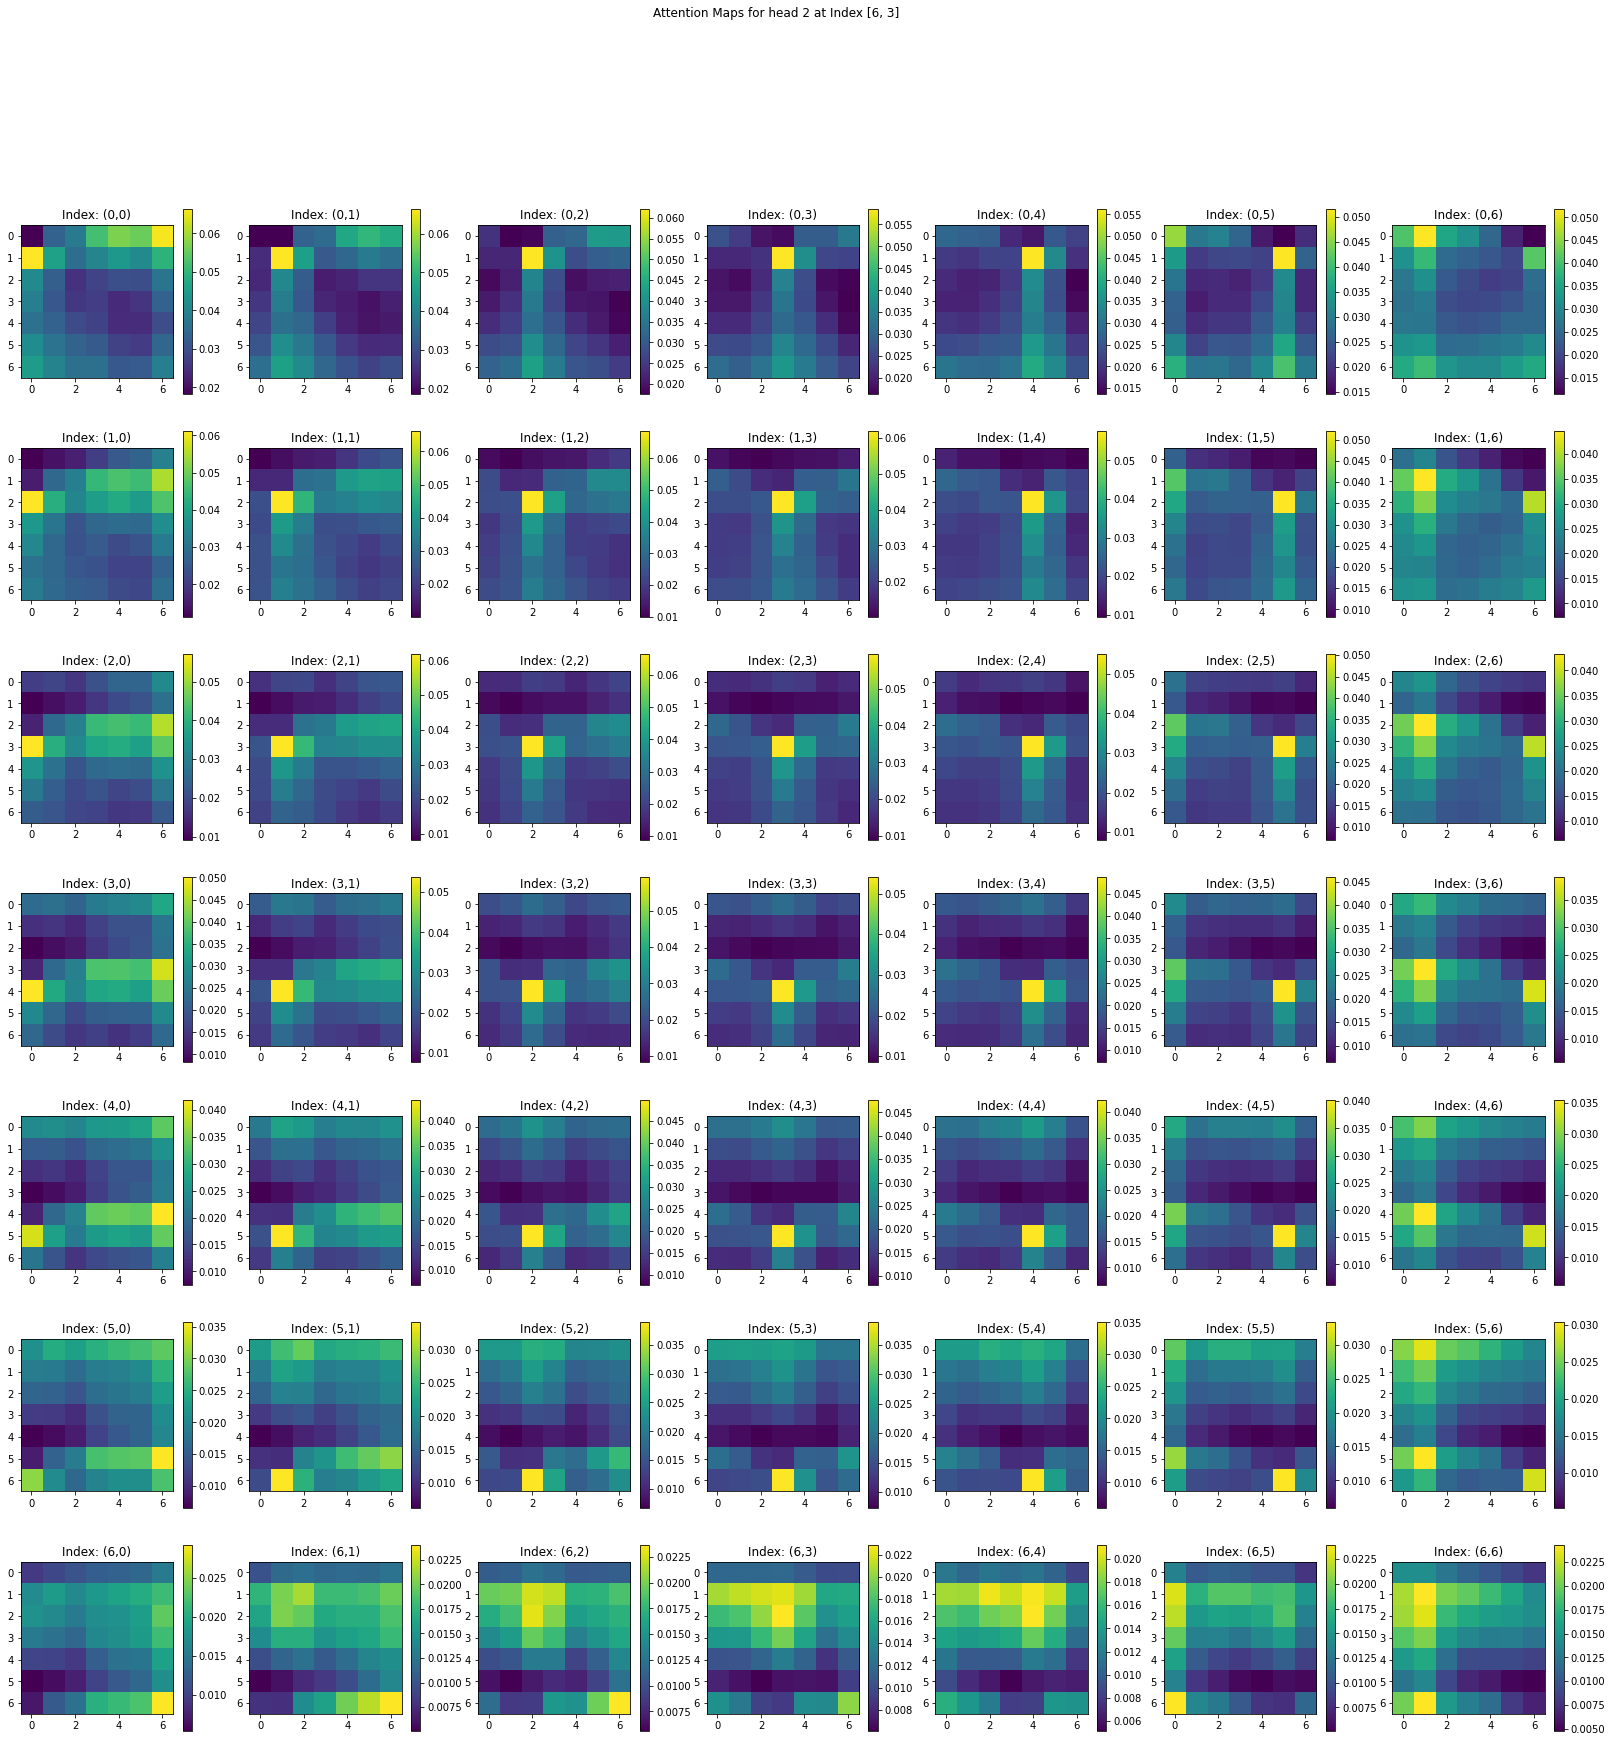

In [341]:
plot_selected_attn(window_attn_matrix, foreground_idx)

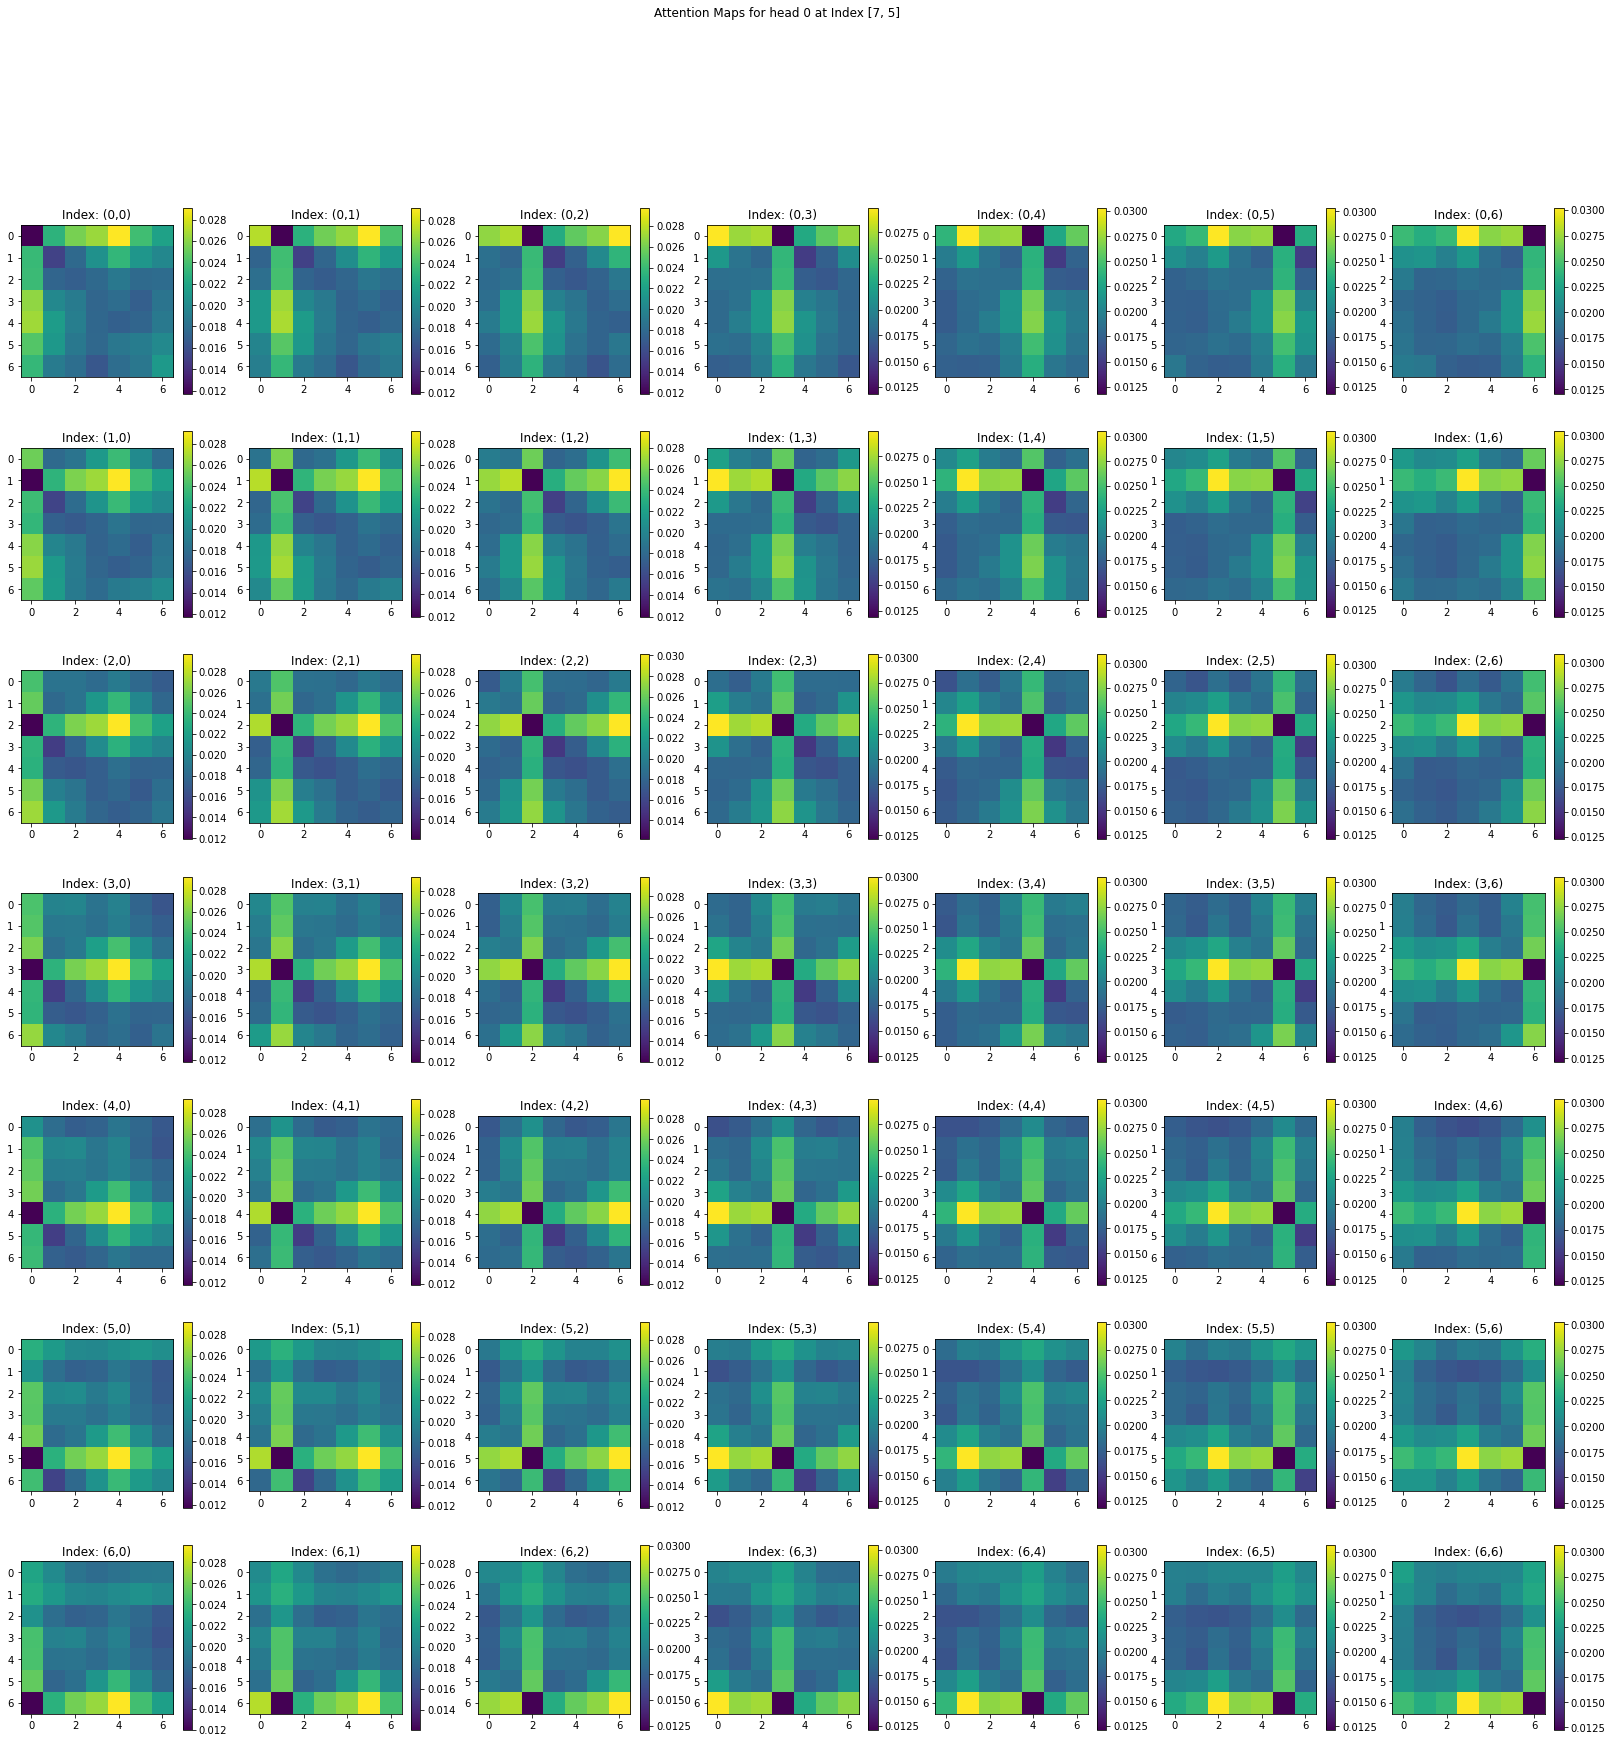

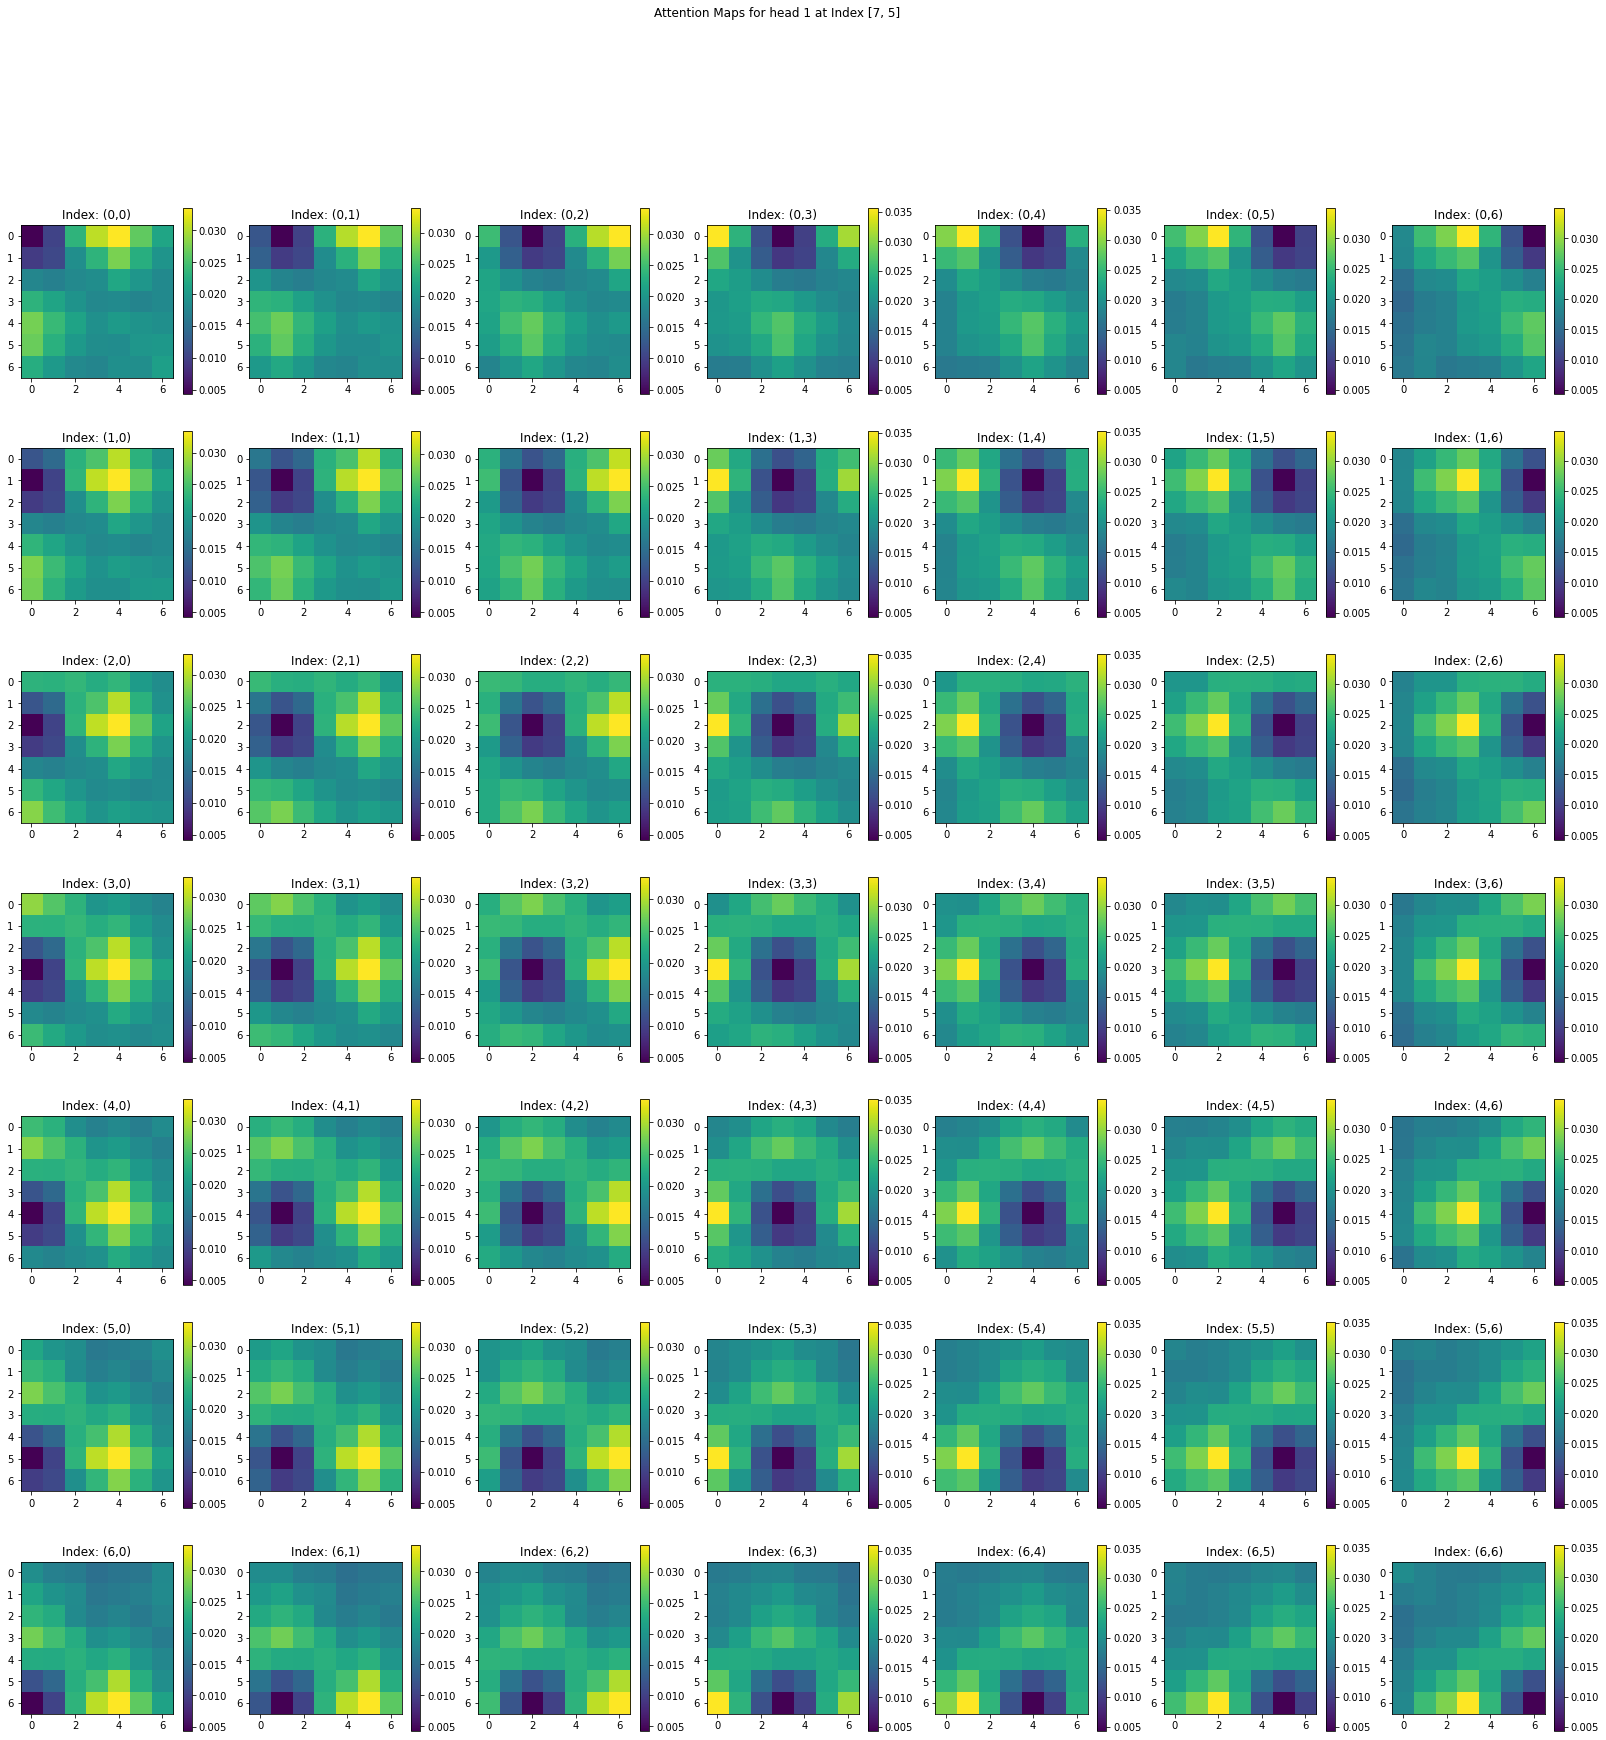

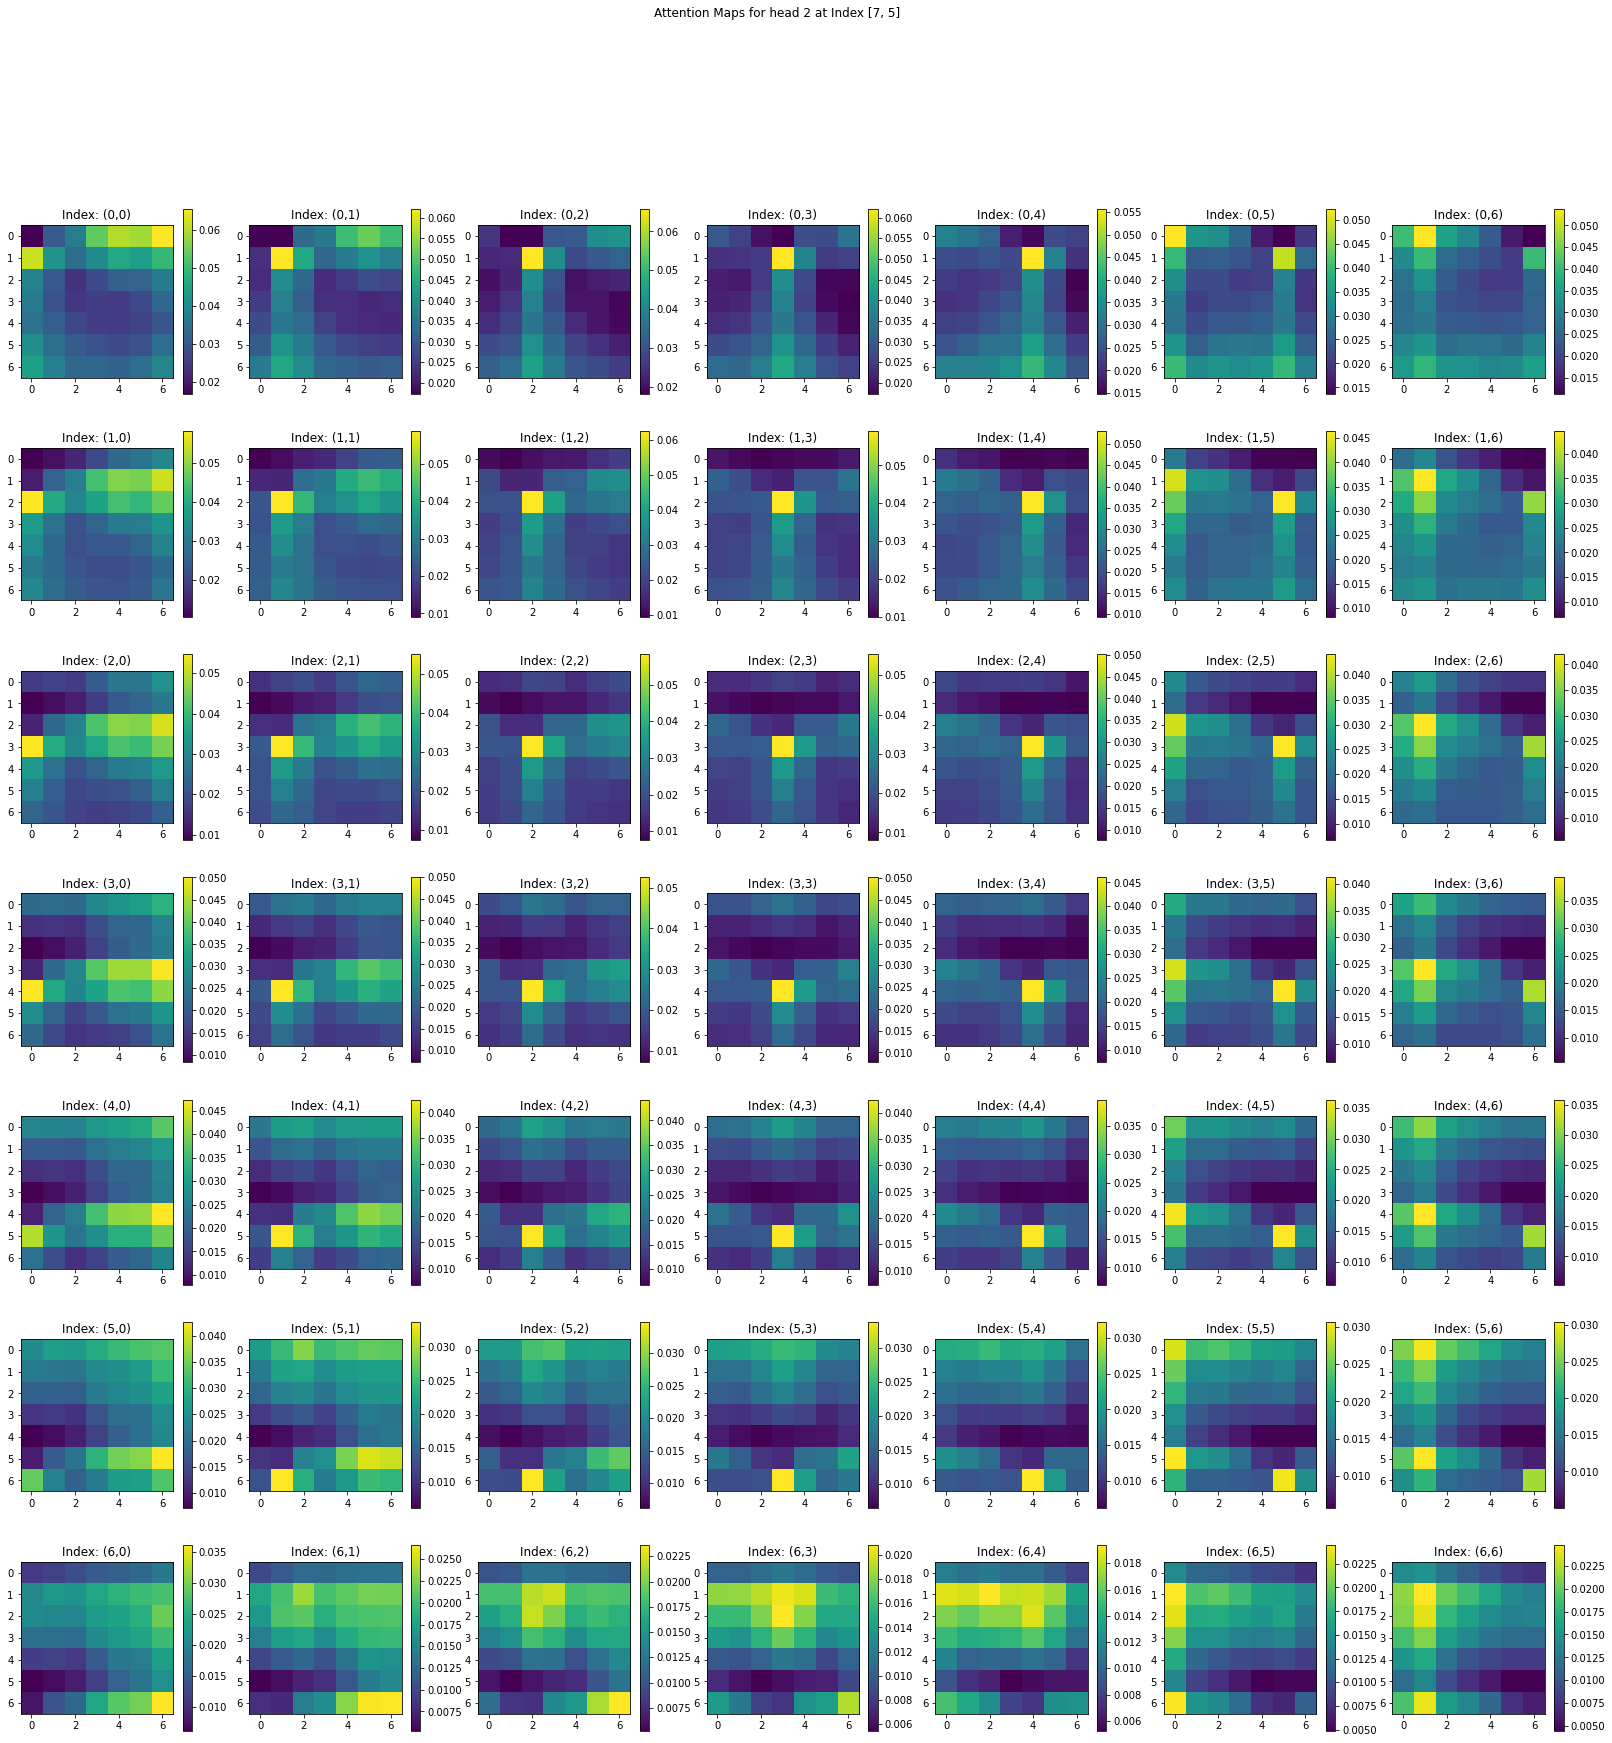

In [344]:
plot_selected_attn(window_attn_matrix, background_idx)

In [ ]:
Nw, h, K2, K2 = window_attn_matrix.shape
side = int(Nw ** .5)
attn_matrix_r = window_attn_matrix.reshape(side, side, h, K2, K2).detach().cpu().numpy()
attn_at_index = attn_matrix_r[foreground_idx[0], foreground_idx[1]]

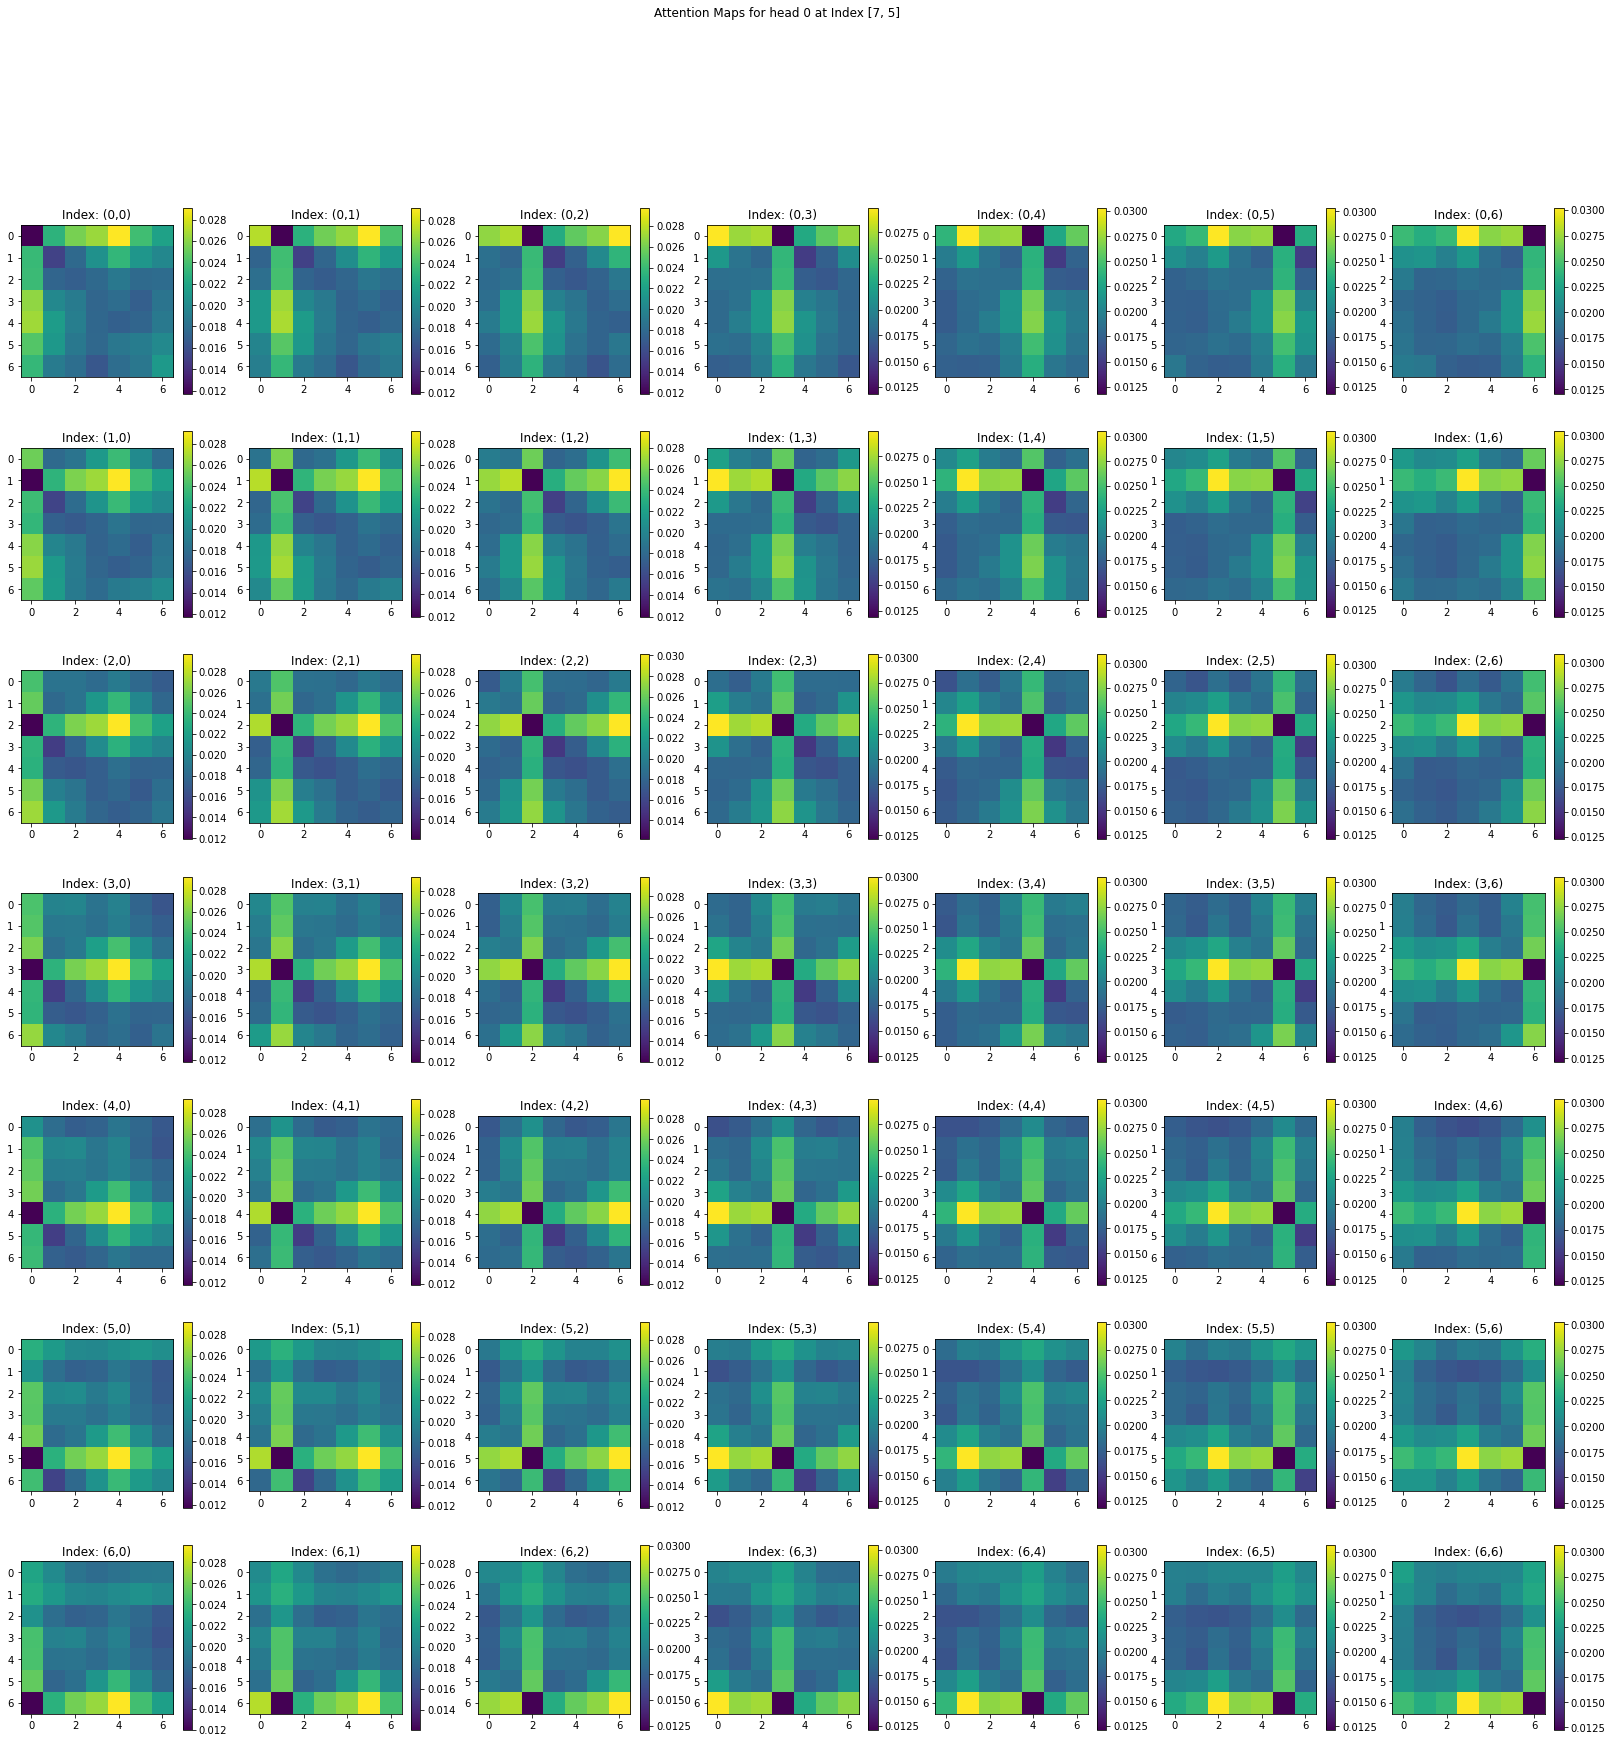

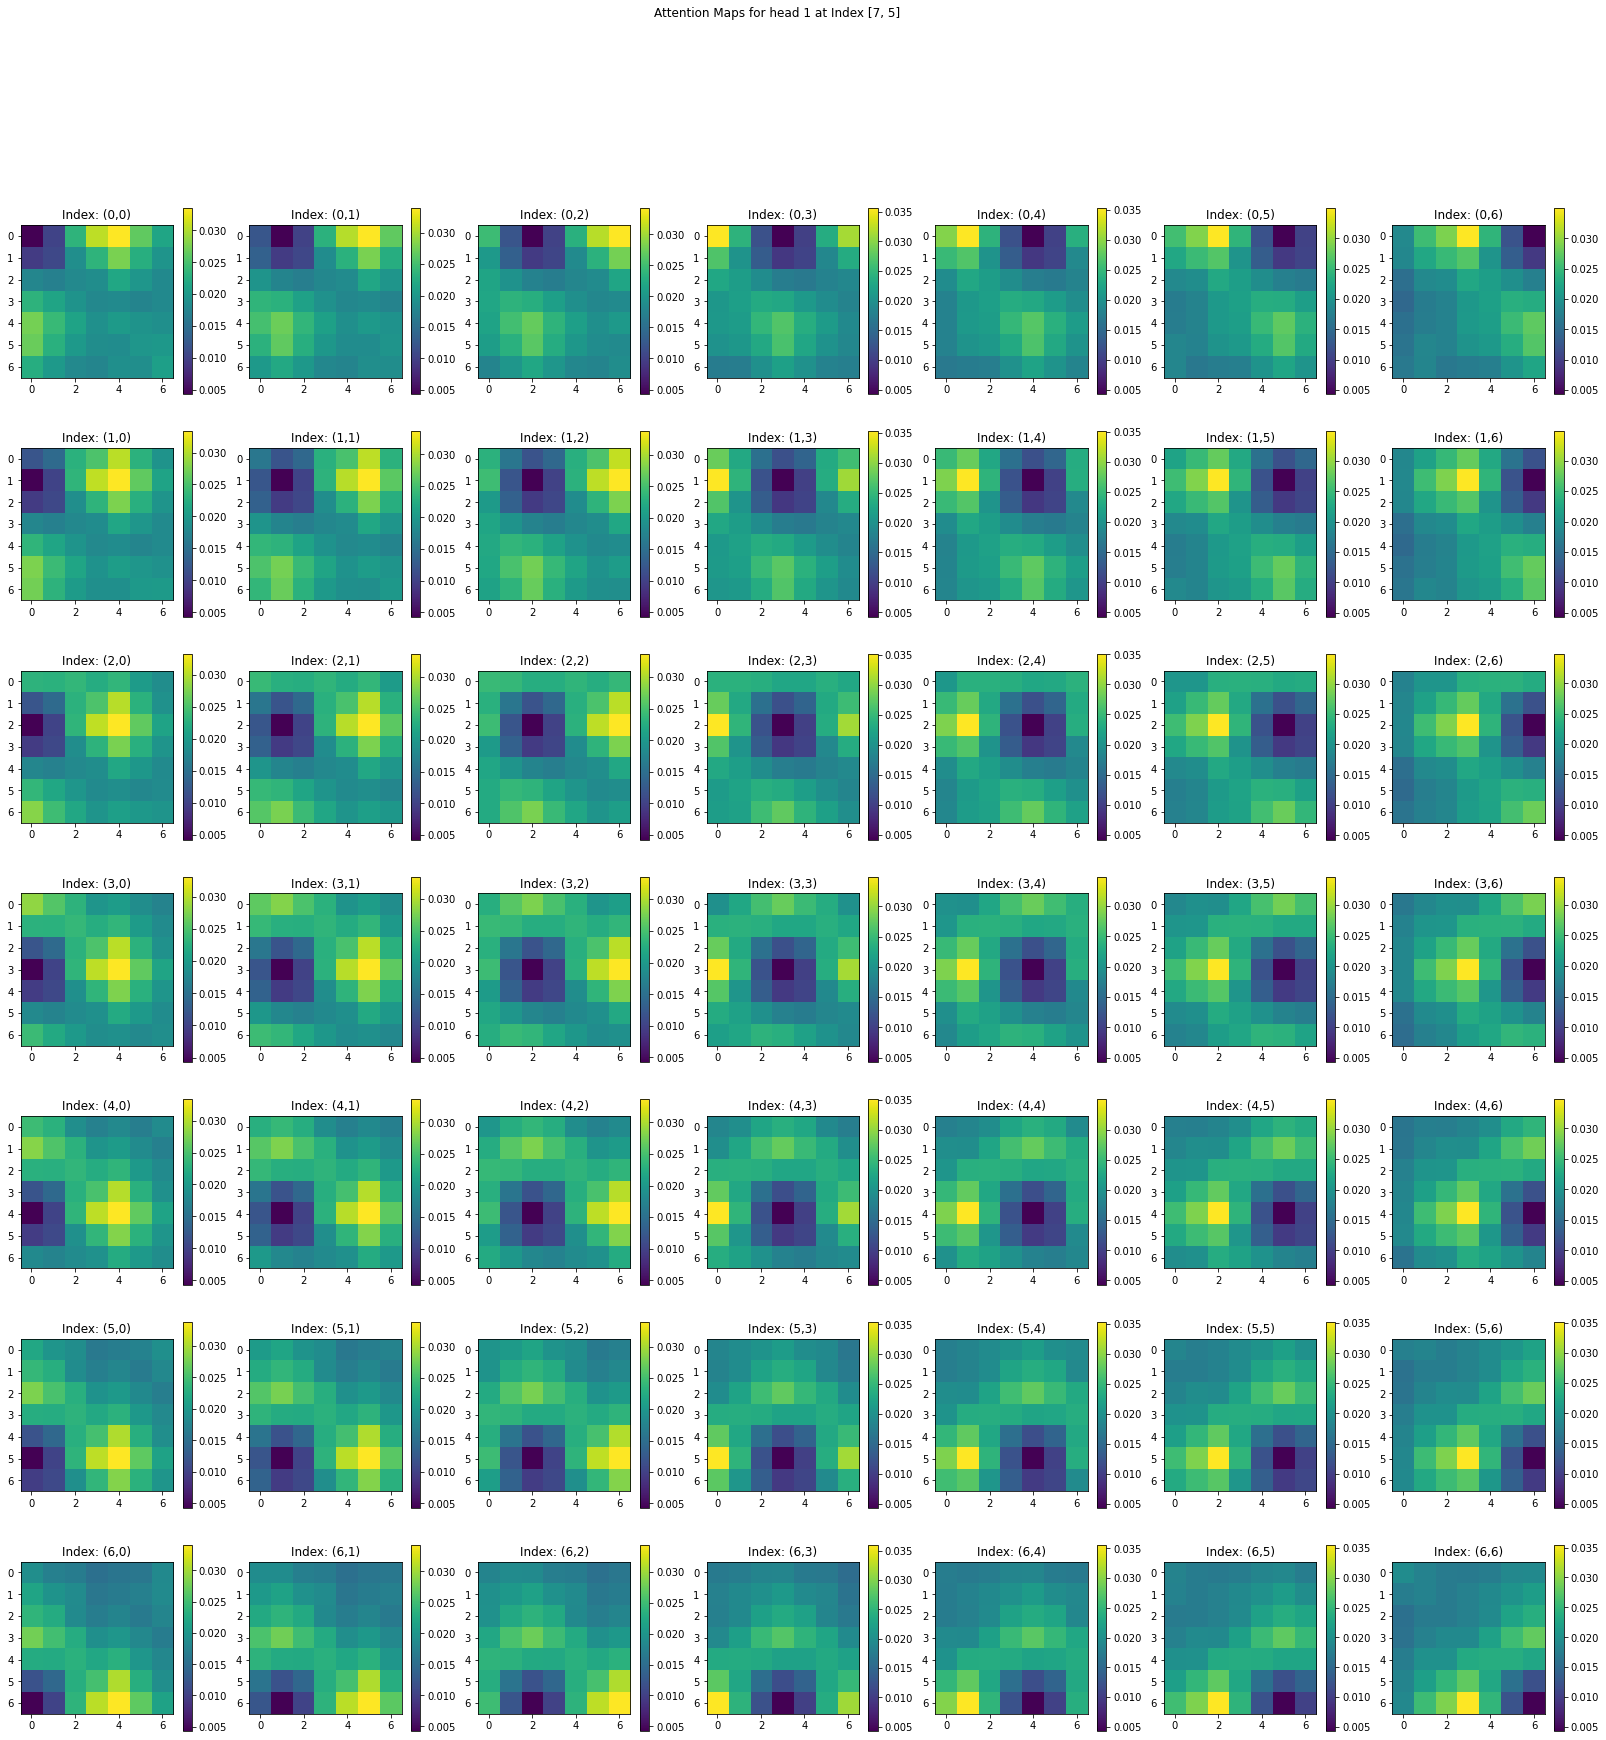

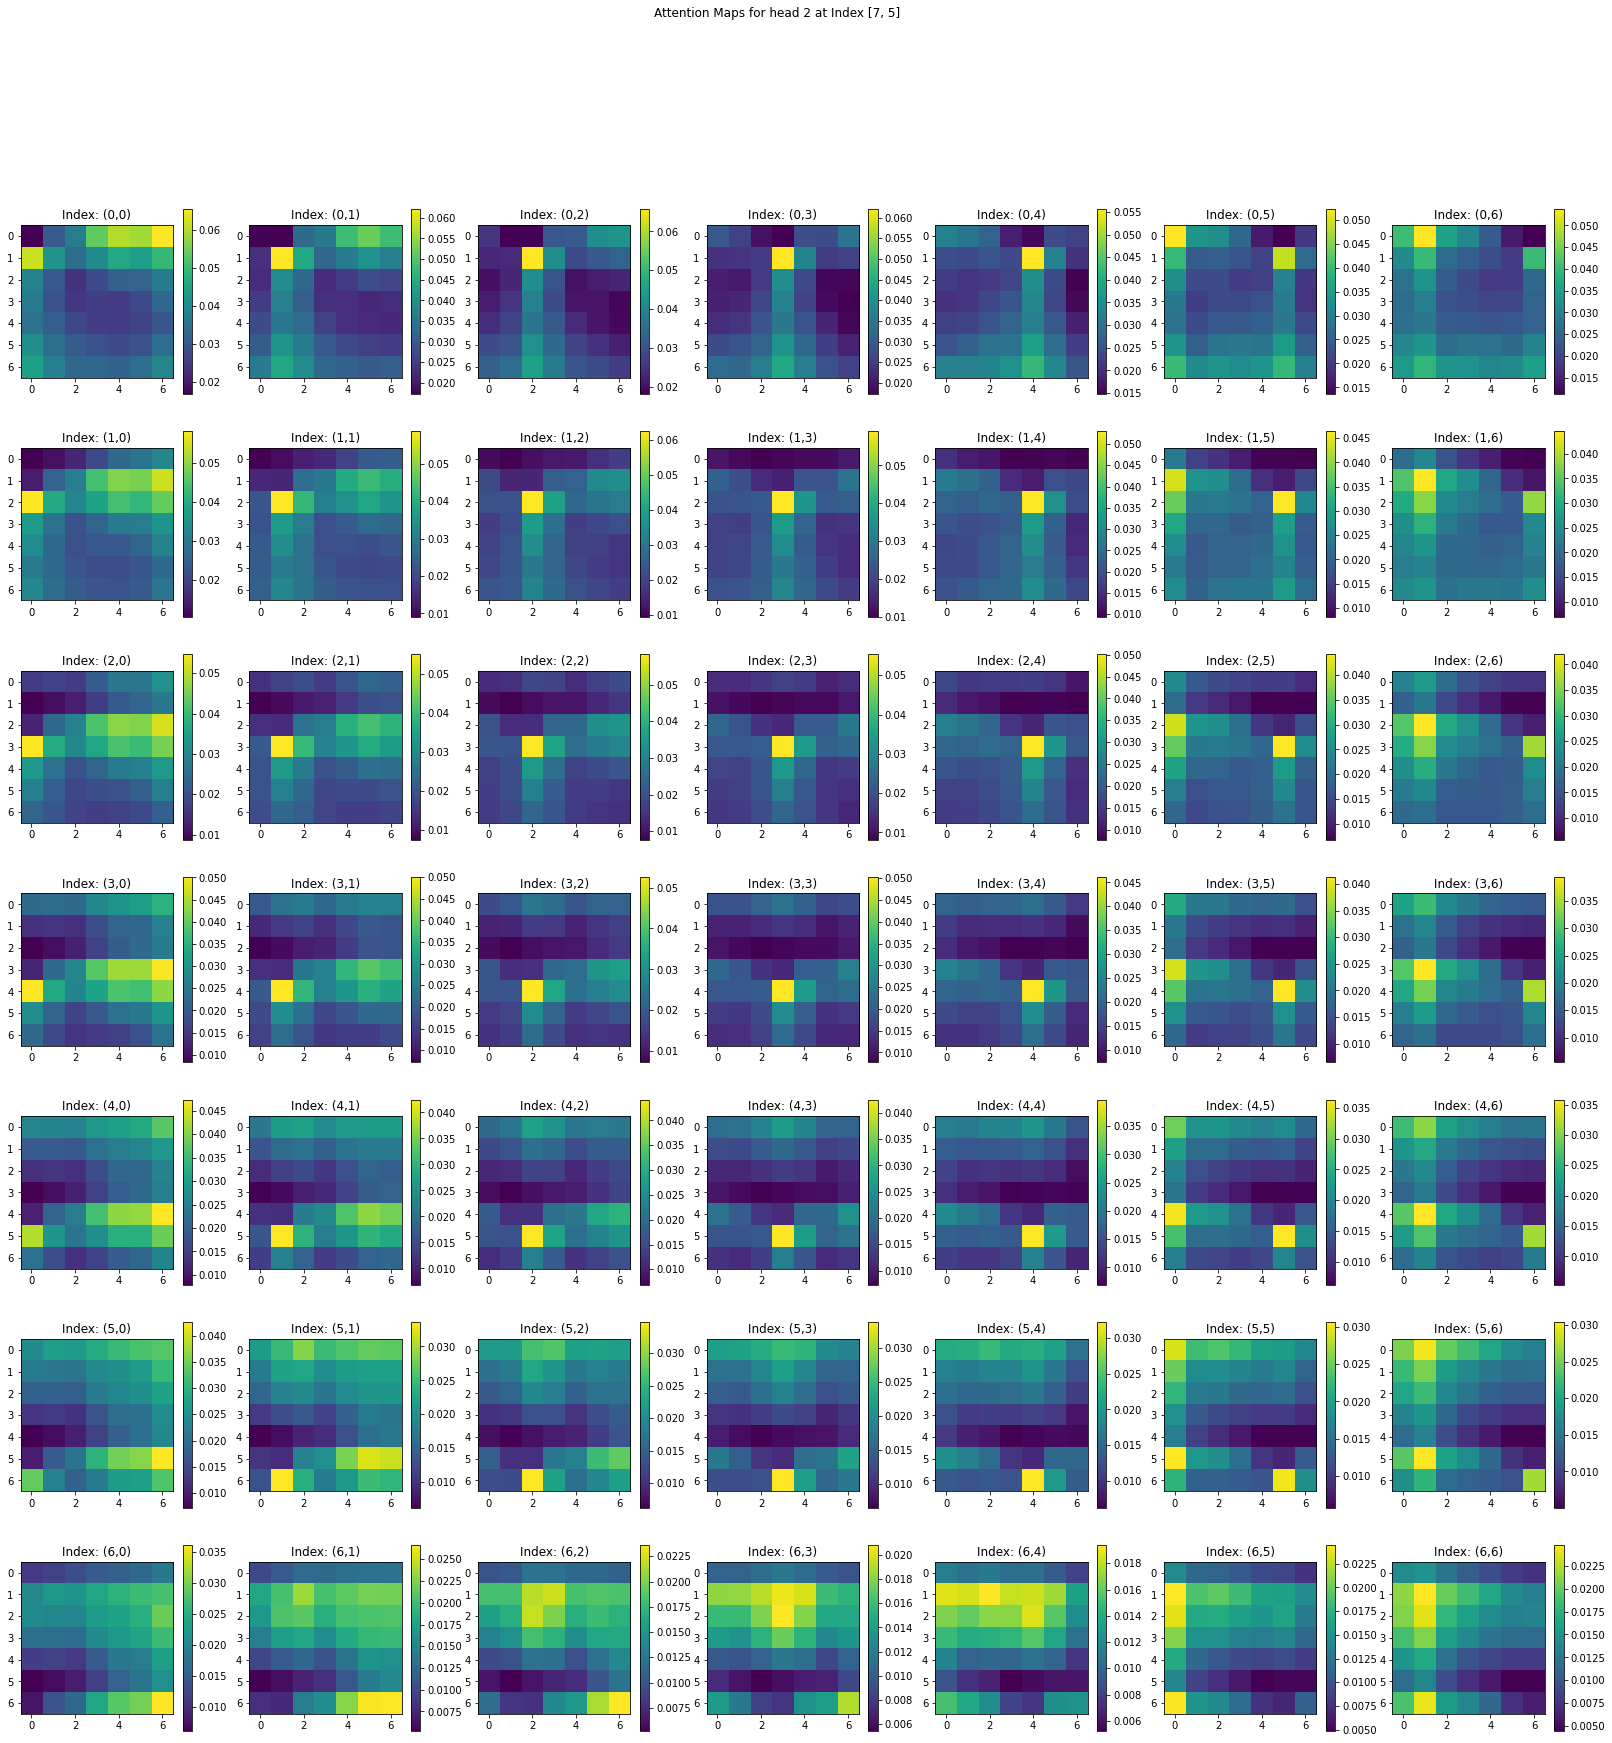

In [343]:
plot_selected_attn(window_attn_matrix, background_idx)

# Entropy Visualizations

#### Helper functions

In [196]:
@torch.no_grad()
def get_class_entropies(data_loader, model, id2label):
    class2correctness2entropies = defaultdict(lambda: defaultdict(lambda: list()))
    model.eval()

    end = time.time()
    count = 0
    for idx, (images, target) in tqdm(enumerate(data_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        outputs = model(images, use_amp=False)
        predictions = outputs.argsort(dim=-1, descending=True)[:, 0].reshape(-1)
        correctness = predictions == target.reshape(-1)
        
        for batch_idx, (is_correct, label, image, output) in enumerate(zip(correctness, target, images, outputs)):
            count += 1
            label = label.detach().cpu().numpy().tolist()
            is_correct = is_correct.detach().cpu().numpy().tolist()
            output_entropy = torch.distributions.Categorical(
                F.softmax(output)
            ).entropy().detach().cpu().numpy().tolist()
            class2correctness2entropies[id2label[label]][is_correct].append(output_entropy)
            
    return class2correctness2entropies

def dataframify_entropy_dict(dictionary):
    flat_dict = {
    'class': [],
    'correct_entropy': [],
    'wrong_entropy': [],
    'overall': []
    }

    for class_name, correctness2entropies in dictionary.items():
        flat_dict['class'].append(class_name)
        for is_correct, entropies in correctness2entropies.items():
            if is_correct:
                flat_dict['correct_entropy'].append(np.mean(entropies))
            else:
                flat_dict['wrong_entropy'].append(np.mean(entropies))
        flat_dict['overall'].append(
            np.concatenate(list(correctness2entropies.values())).mean()
        )
    return pd.DataFrame(data=flat_dict)

#### Get class entropy distributions

In [197]:
bl_class2correctness2entropies = get_class_entropies(bl_data_loader_val, bl_model, id2label)
our_class2correctness2entropies = get_class_entropies(our_data_loader_val, our_model, id2label)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
79it [00:19,  3.99it/s]
79it [00:23,  3.38it/s]


#### Turn dicts into dataframes for plotting

In [198]:
bl_entropy_df = dataframify_entropy_dict(bl_class2correctness2entropies)
bl_entropy_df = bl_entropy_df.set_index('class')

our_entropy_df = dataframify_entropy_dict(our_class2correctness2entropies)
our_entropy_df = our_entropy_df.set_index('class')

In [199]:
ratio_df = bl_entropy_df.divide(our_entropy_df, axis="columns")
ratio_df

,correct_entropy,wrong_entropy,overall
class,,,
mountain,0.949765,1.047371,0.969470
forest,1.050862,1.039968,1.030577
seal,0.869535,0.977781,0.932079
mushroom,0.592459,0.906275,0.745426
sea,0.744261,0.947434,0.797120
...,...,...,...
telephone,0.951680,0.940958,0.985831
bed,0.971830,0.905650,0.995186
motorcycle,0.816034,0.932312,0.837277


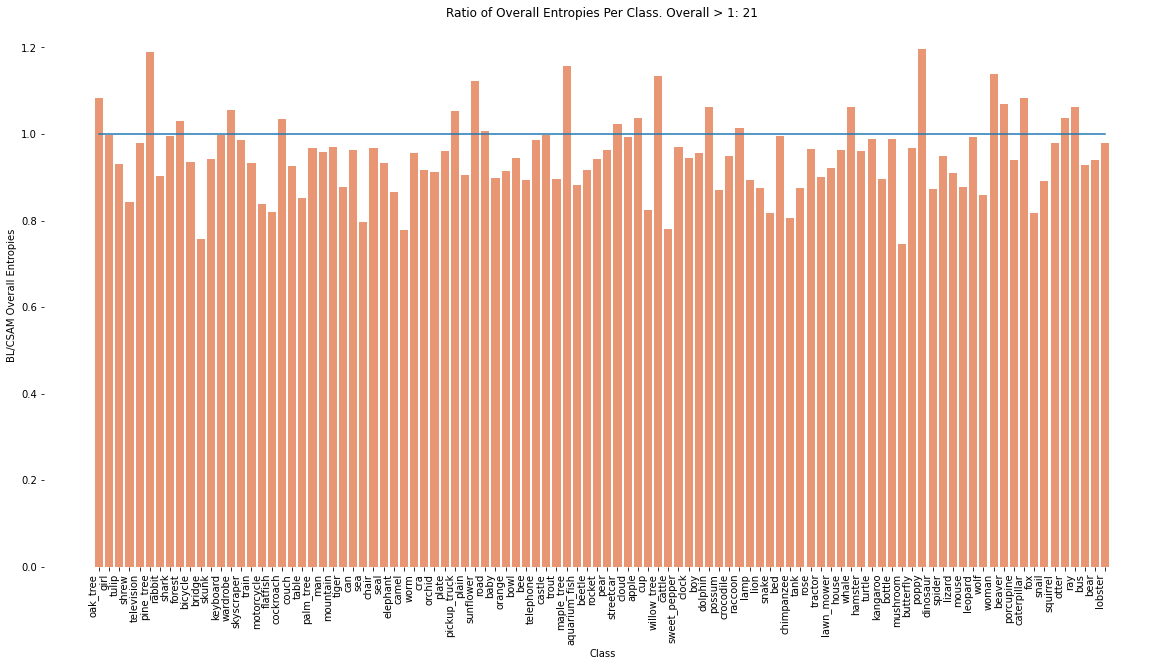

In [200]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['overall'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Overall Entropies")
plt.xlabel("Class")
plt.title("Ratio of Overall Entropies Per Class. Overall > 1: {}".format((ratio_df['overall'] > 1.).sum()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

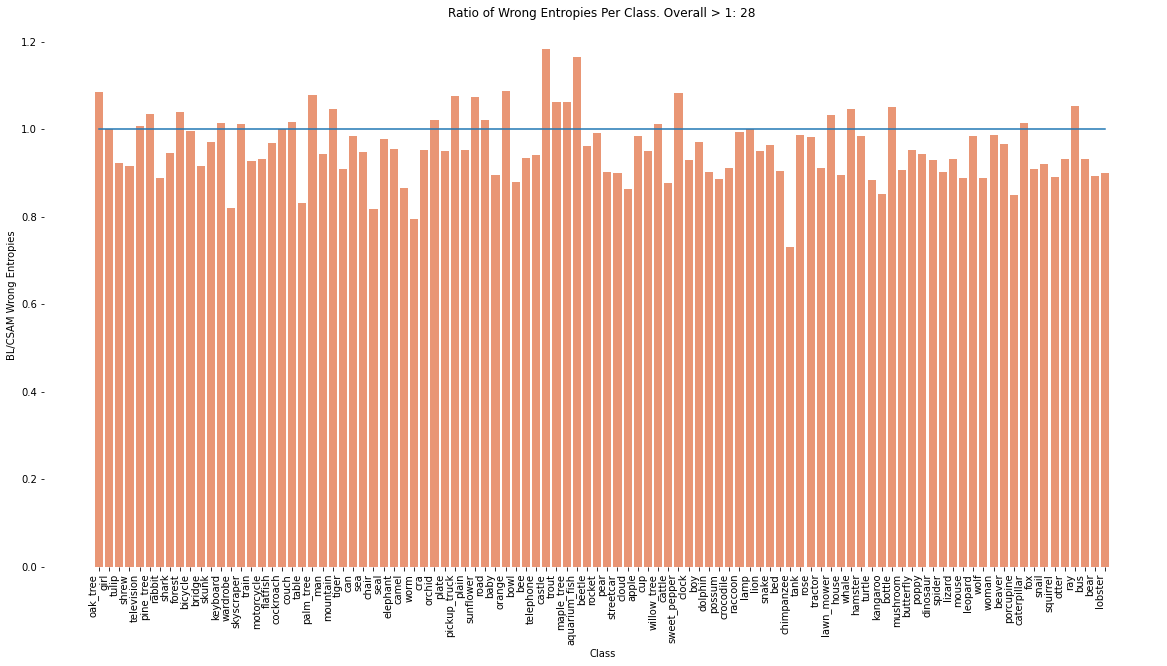

In [201]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['wrong_entropy'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Wrong Entropies")
plt.xlabel("Class")
plt.title("Ratio of Wrong Entropies Per Class. Overall > 1: {}".format((ratio_df['wrong_entropy'] > 1.).sum()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [202]:
(ratio_df['wrong_entropy'] > 1.).sum()

28

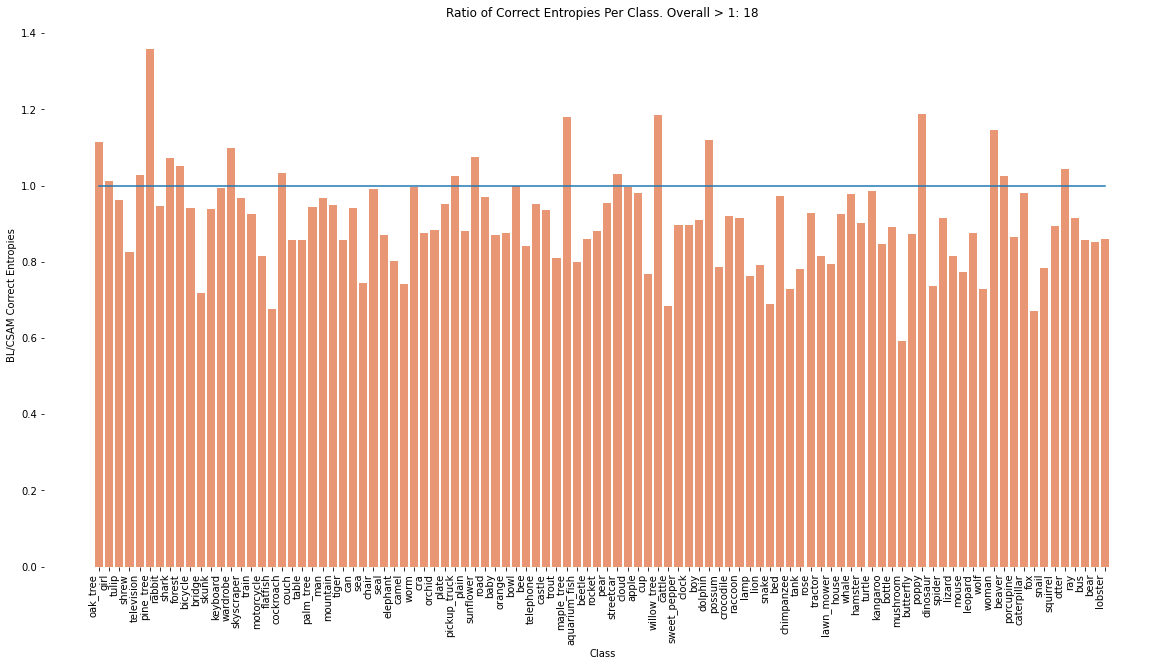

In [203]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['correct_entropy'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Correct Entropies")
plt.xlabel("Class")
plt.title("Ratio of Correct Entropies Per Class. Overall > 1: {}".format((ratio_df['correct_entropy'] > 1.).sum()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [204]:
(ratio_df['correct_entropy'] > 1.).sum()

18

# General Attention Maps